# Payments prediction with Neural Network

In this notebook we shall provide the prediction of default payments made by clients in Taiwan from April to Semptember 2005. The execution of the Neural Network will be made step by step.

## Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16,10

RANDOM_SEED = 60

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

## Exploration

In [3]:
print(f"Shape x test {X_test.shape}")
print(f"Shape x train {X_train.shape}")
print(f"Shape y train {y_train.shape}")

Shape x test (6000, 24)
Shape x train (24000, 24)
Shape y train (24000, 2)


In [4]:
X_train.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [5]:
X_test.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [6]:
y_train.columns

Index(['ID', 'default.payment.next.month'], dtype='object')

In [7]:
## First we verify if we have any missing data

missing = X_train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [8]:
missing_y = y_train.isnull().sum()
missing_y[missing_y > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [9]:
X_train.index = X_train.ID
X_test.index = X_test.ID

In [10]:
# Droppping the ID column
X_train.drop('ID',axis=1,inplace=True)
X_test.drop('ID',axis=1,inplace=True)

In [11]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,5,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [12]:
X_test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
2309,30000.0,1,2,2,25,0,0,0,0,0,...,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
22405,150000.0,2,1,2,26,0,0,0,0,0,...,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
23398,70000.0,2,3,1,32,0,0,0,0,0,...,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
25059,130000.0,1,3,2,49,0,0,0,0,0,...,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
2665,50000.0,2,2,2,36,0,0,0,0,0,...,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0


In [13]:
y_train = y_train.rename(columns={"default.payment.next.month":"def_payment"})

In [14]:
X_test.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [15]:
X_train.SEX.value_counts(dropna=False)

2    14518
1     9482
Name: SEX, dtype: int64

In [16]:
X_train.EDUCATION.value_counts(dropna=False)

2    11186
1     8481
3     3959
5      224
4       97
6       43
0       10
Name: EDUCATION, dtype: int64

In [17]:
X_train = X_train.rename(columns={"PAY_0":"PAY_1"})
X_test = X_test.rename(columns={"PAY_0":"PAY_1"})

X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,5,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [18]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

## Data visualization

Text(0.5, 1.0, 'SEX - COUNT')

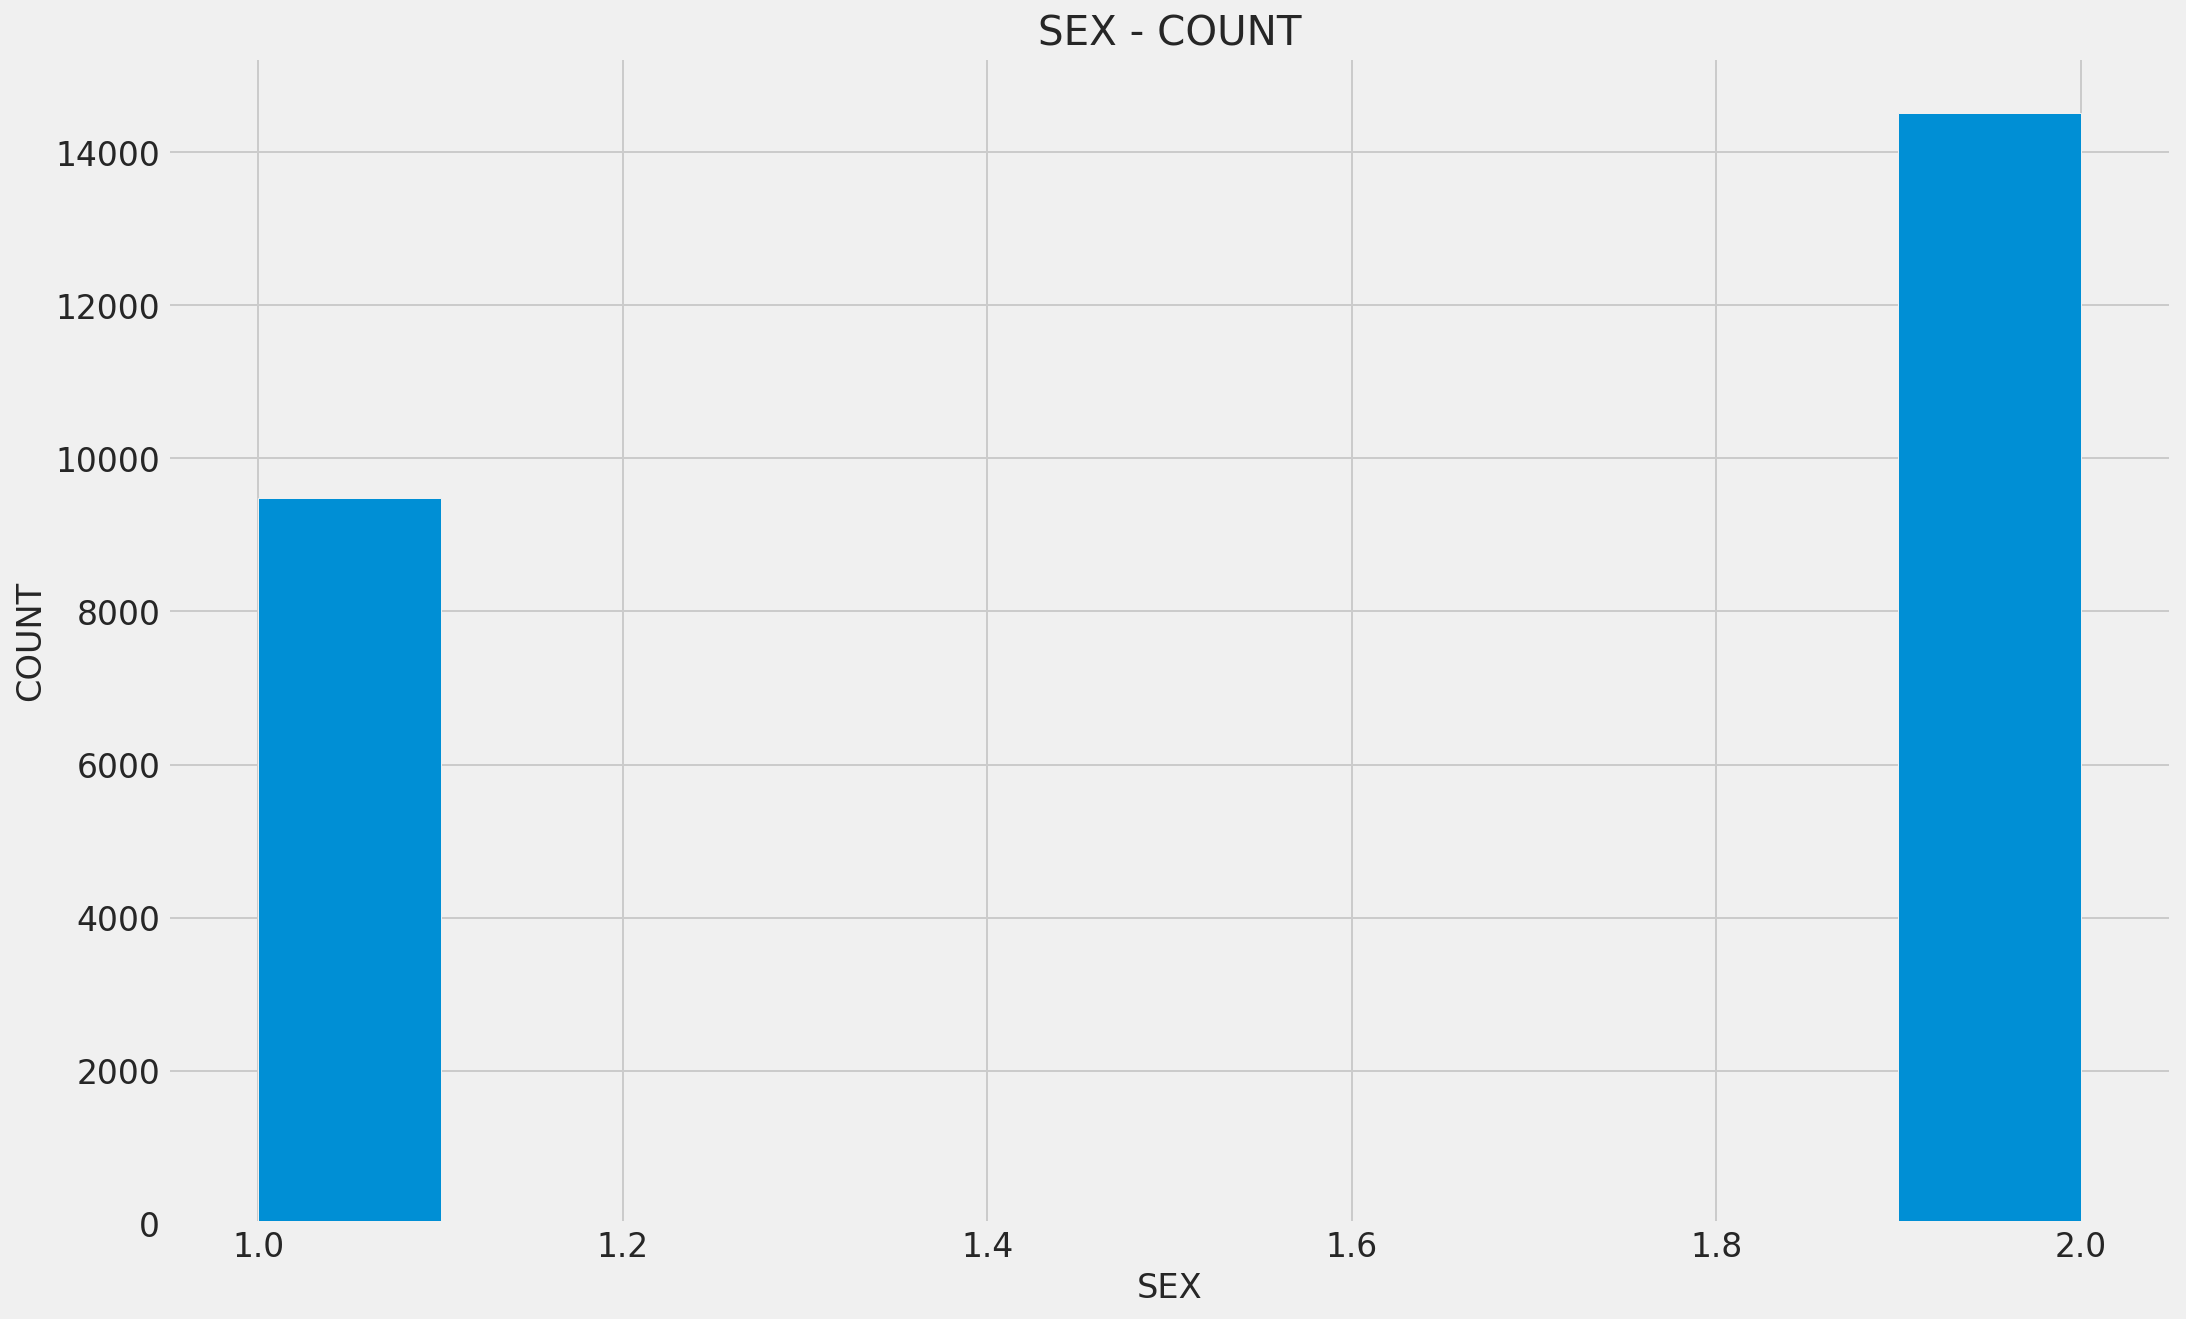

In [19]:
plt.style.use('fivethirtyeight')
X_train.SEX.hist()
plt.xlabel('SEX')
plt.ylabel('COUNT')
plt.title('SEX - COUNT')

Text(0.5, 1.0, 'Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')

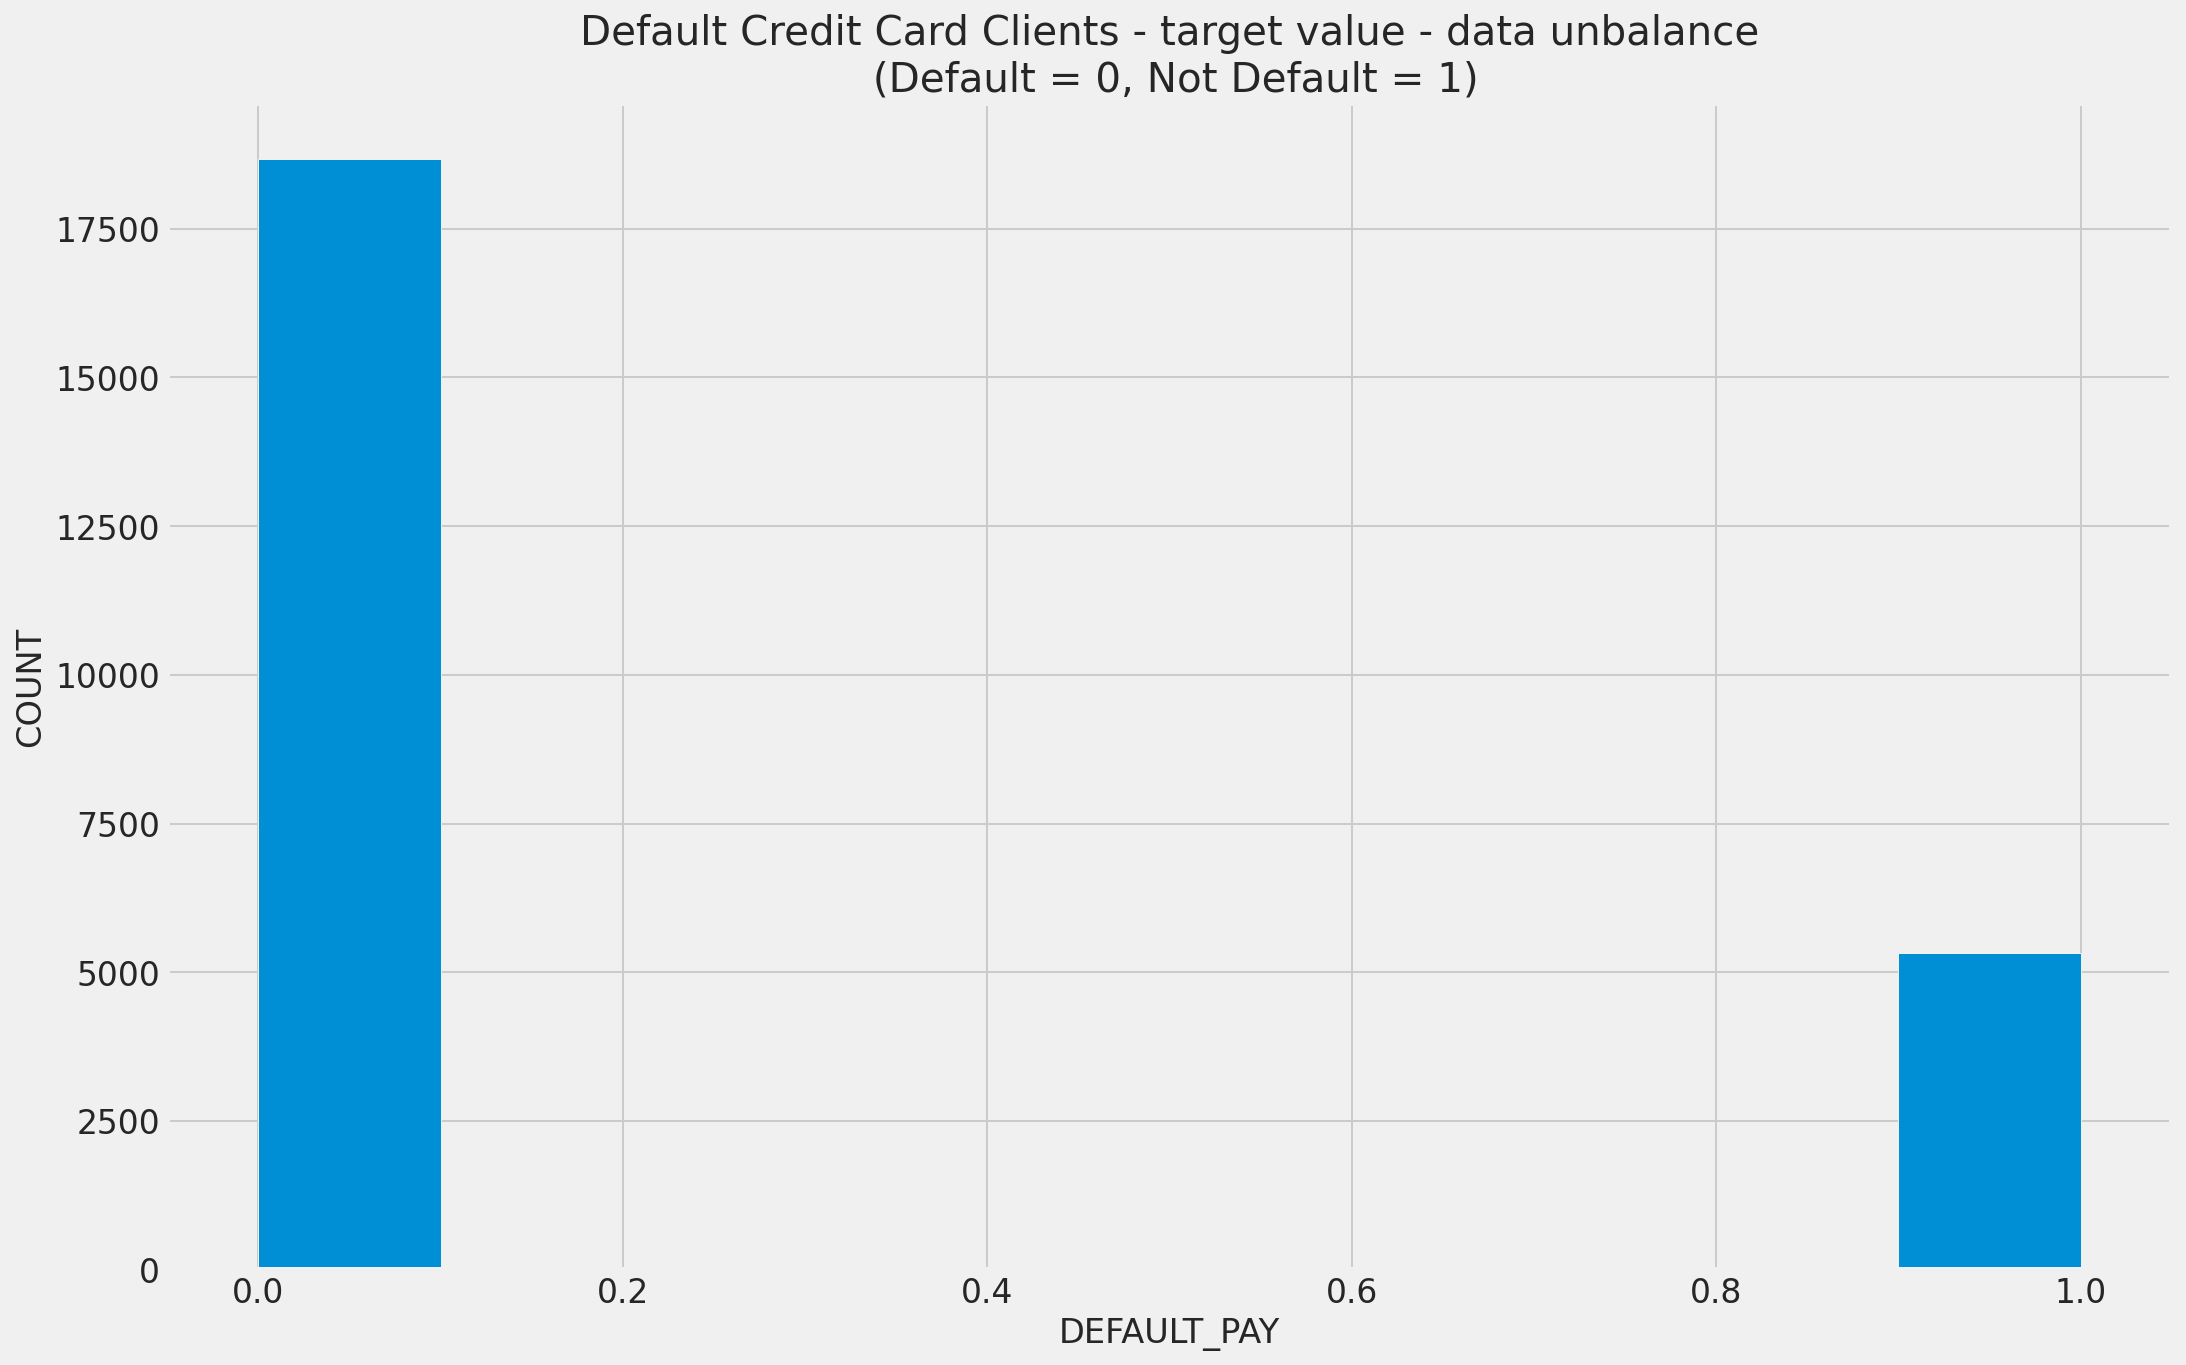

In [20]:
plt.style.use('fivethirtyeight')
y_train.def_payment.hist()
plt.xlabel('DEFAULT_PAY')
plt.ylabel('COUNT')
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')

Text(0.5, 1.0, 'EDUCATION - COUNT')

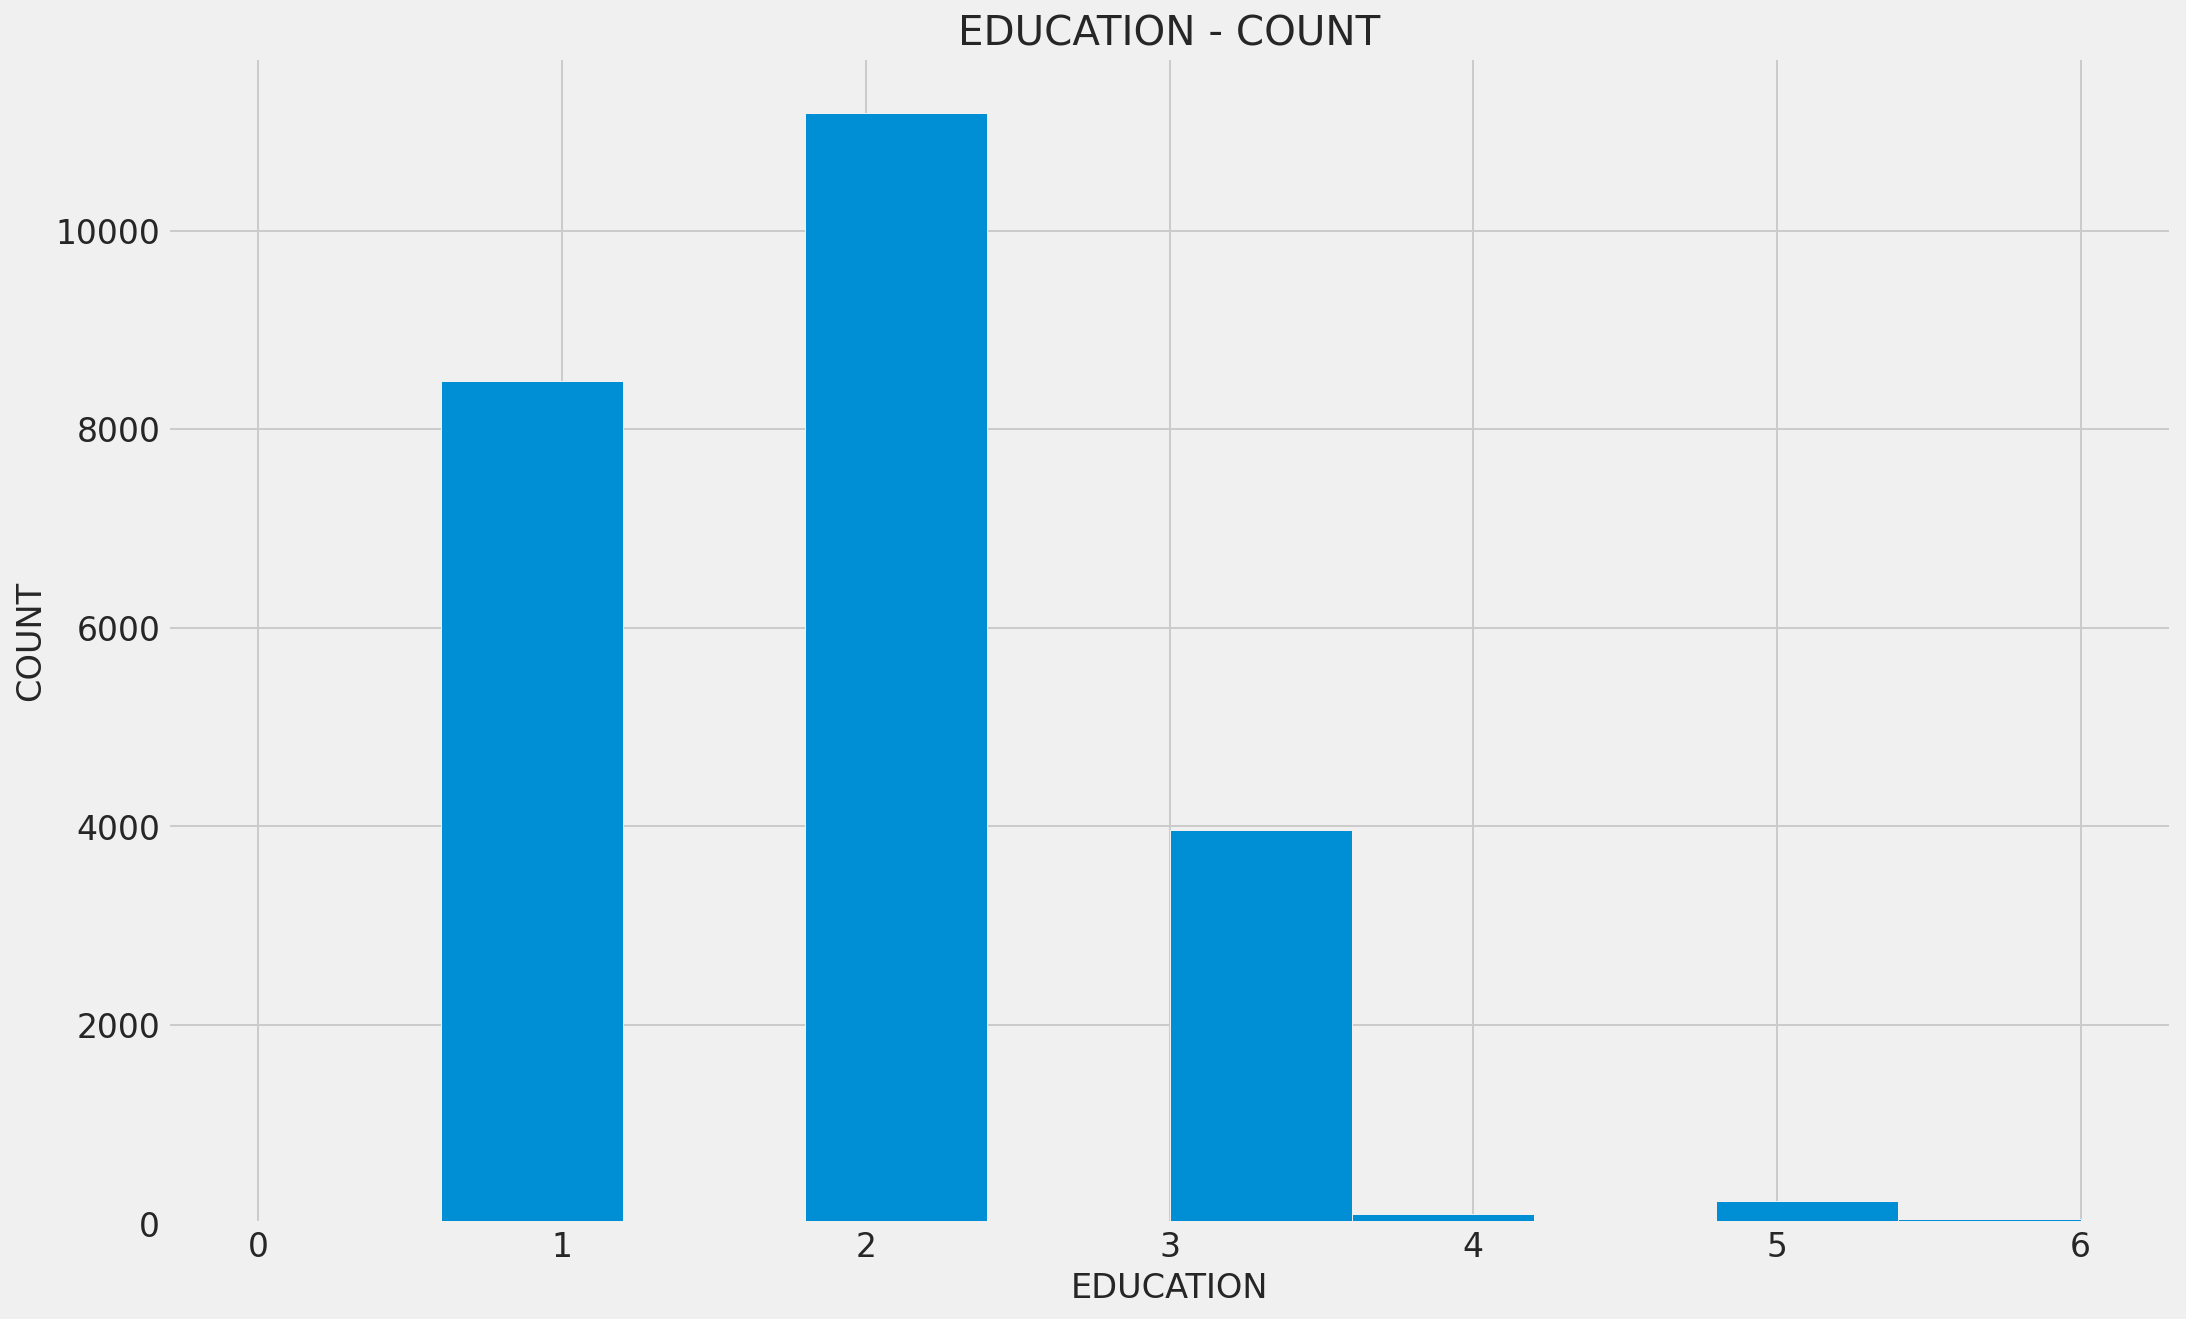

In [21]:
plt.style.use('fivethirtyeight')
X_train.EDUCATION.hist()
plt.xlabel('EDUCATION')
plt.ylabel('COUNT')
plt.title('EDUCATION - COUNT')

Text(0.5, 1.0, 'MARRIAGE - COUNT')

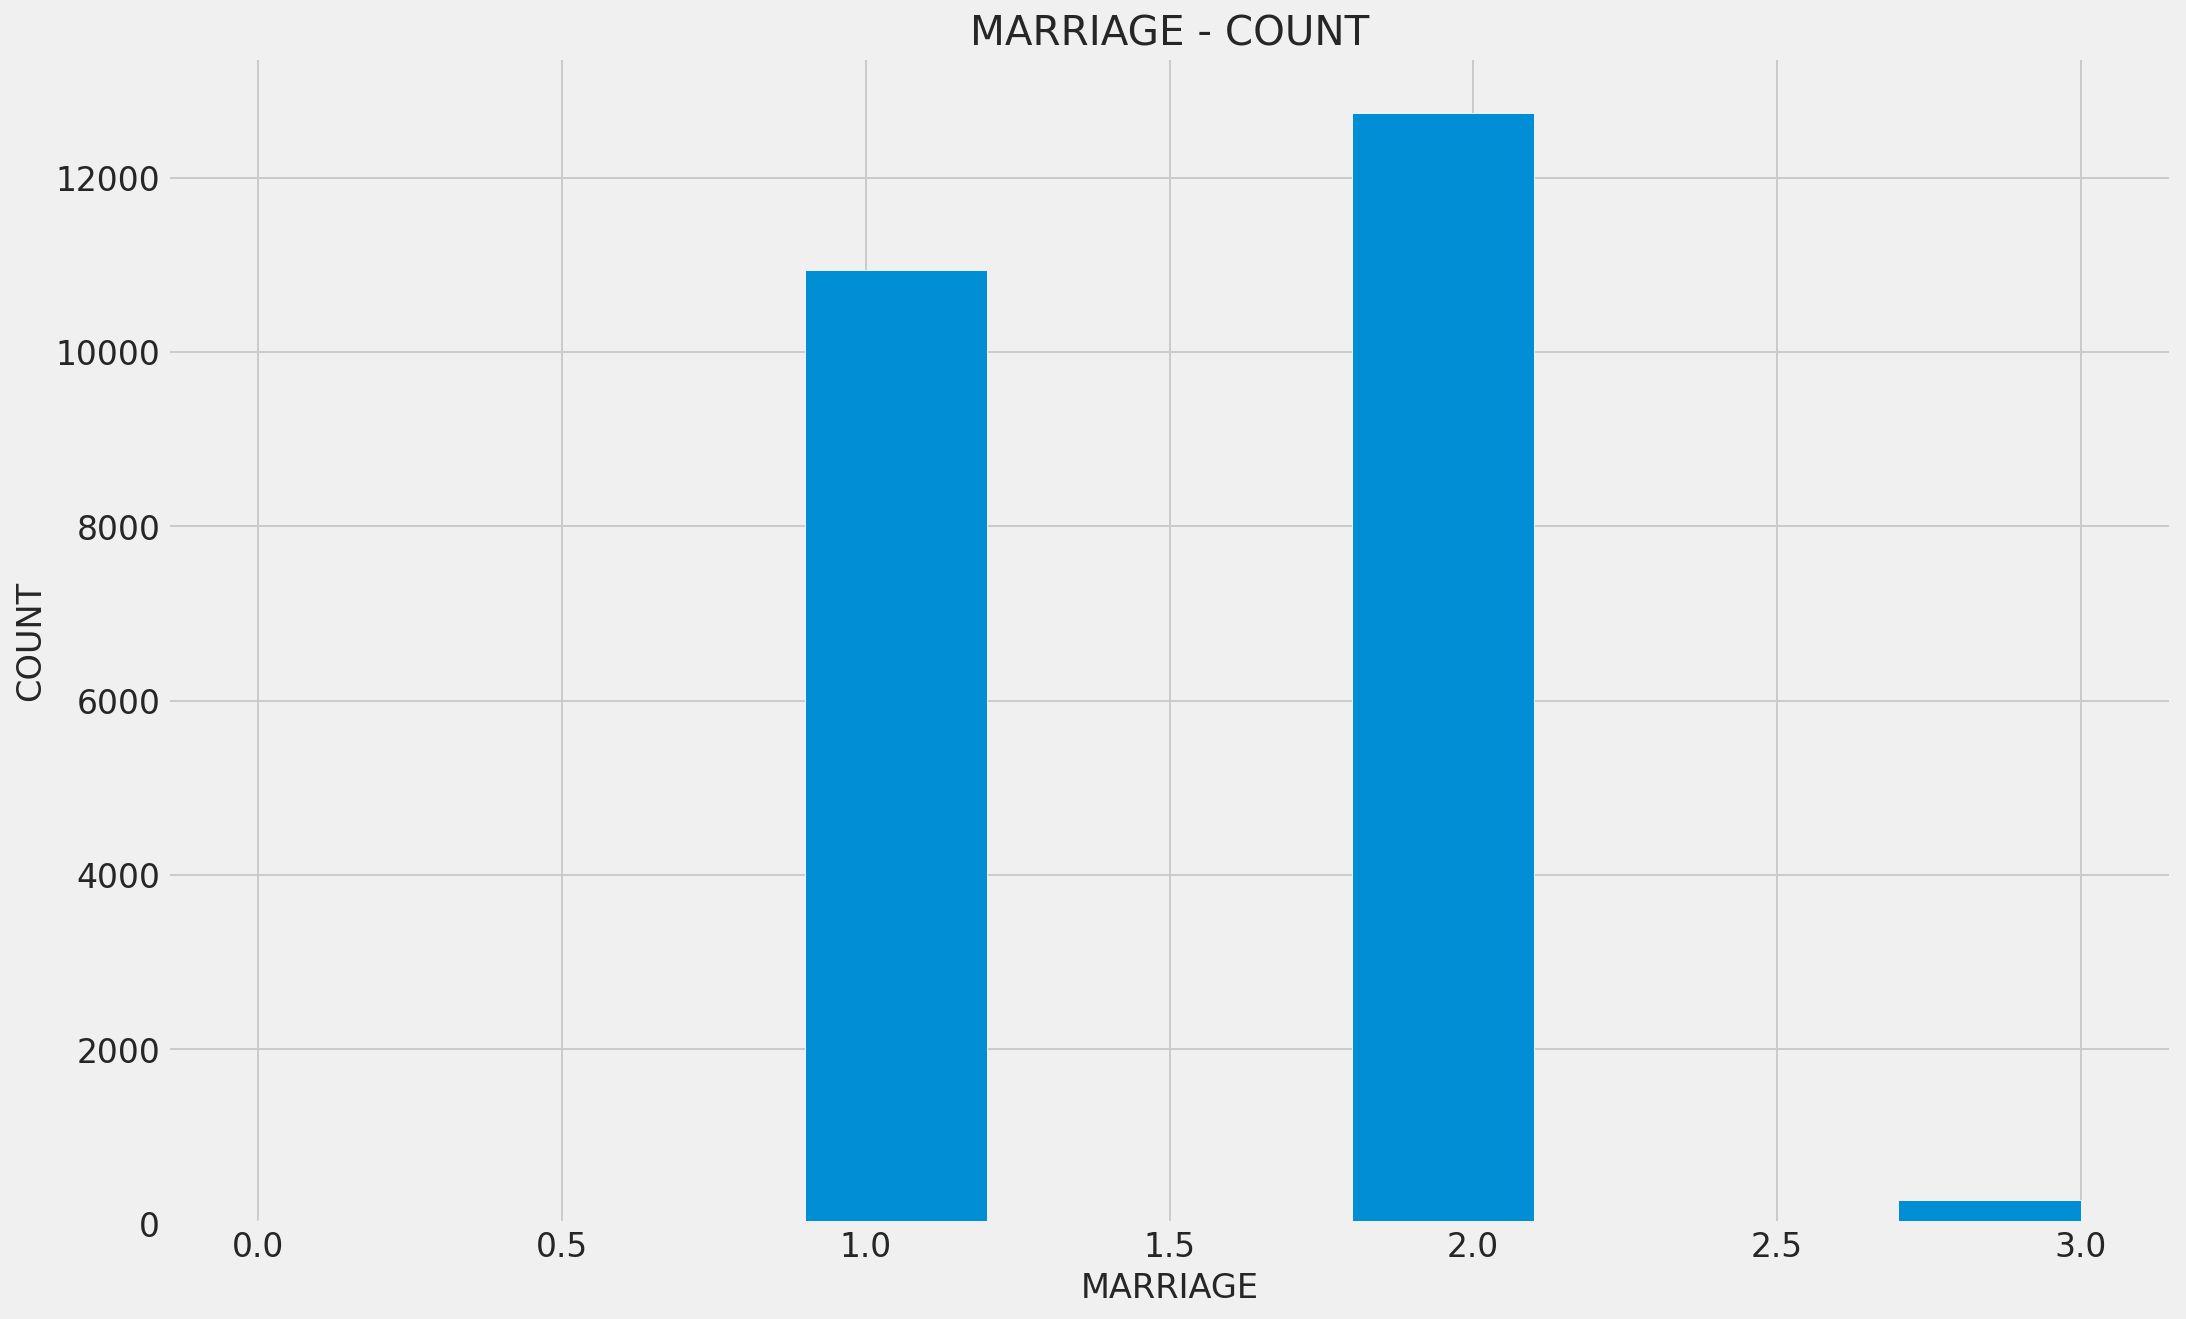

In [22]:
plt.style.use('fivethirtyeight')
X_train.MARRIAGE.hist()
plt.xlabel('MARRIAGE')
plt.ylabel('COUNT')
plt.title('MARRIAGE - COUNT')

<AxesSubplot:xlabel='SEX', ylabel='LIMIT_BAL'>

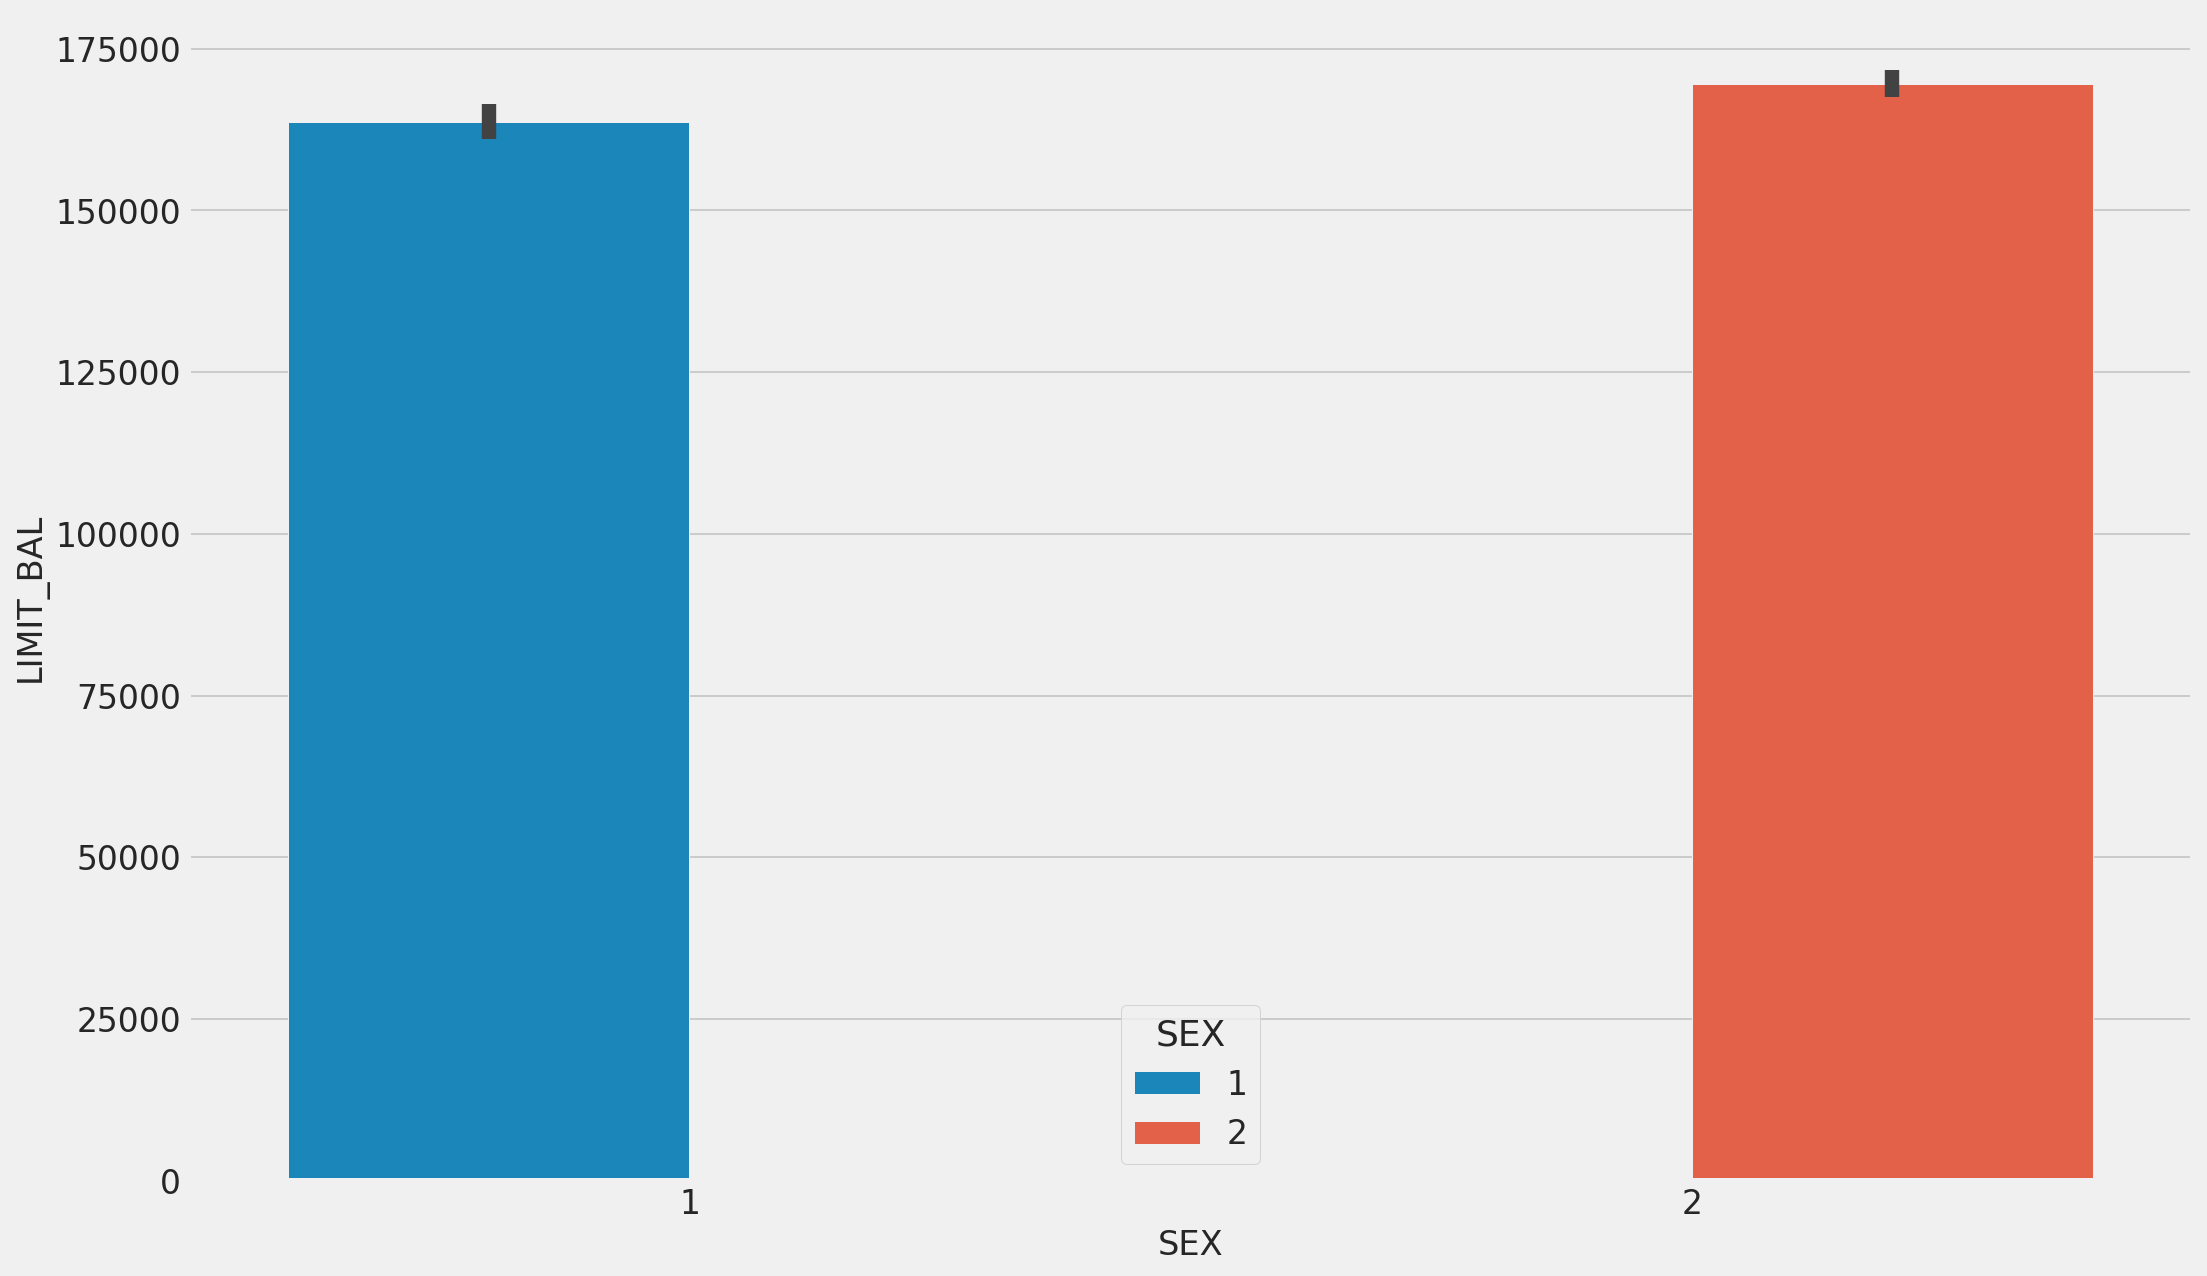

In [23]:
sns.barplot(x='SEX',y='LIMIT_BAL',data=X_train,hue='SEX')

<AxesSubplot:xlabel='SEX', ylabel='count'>

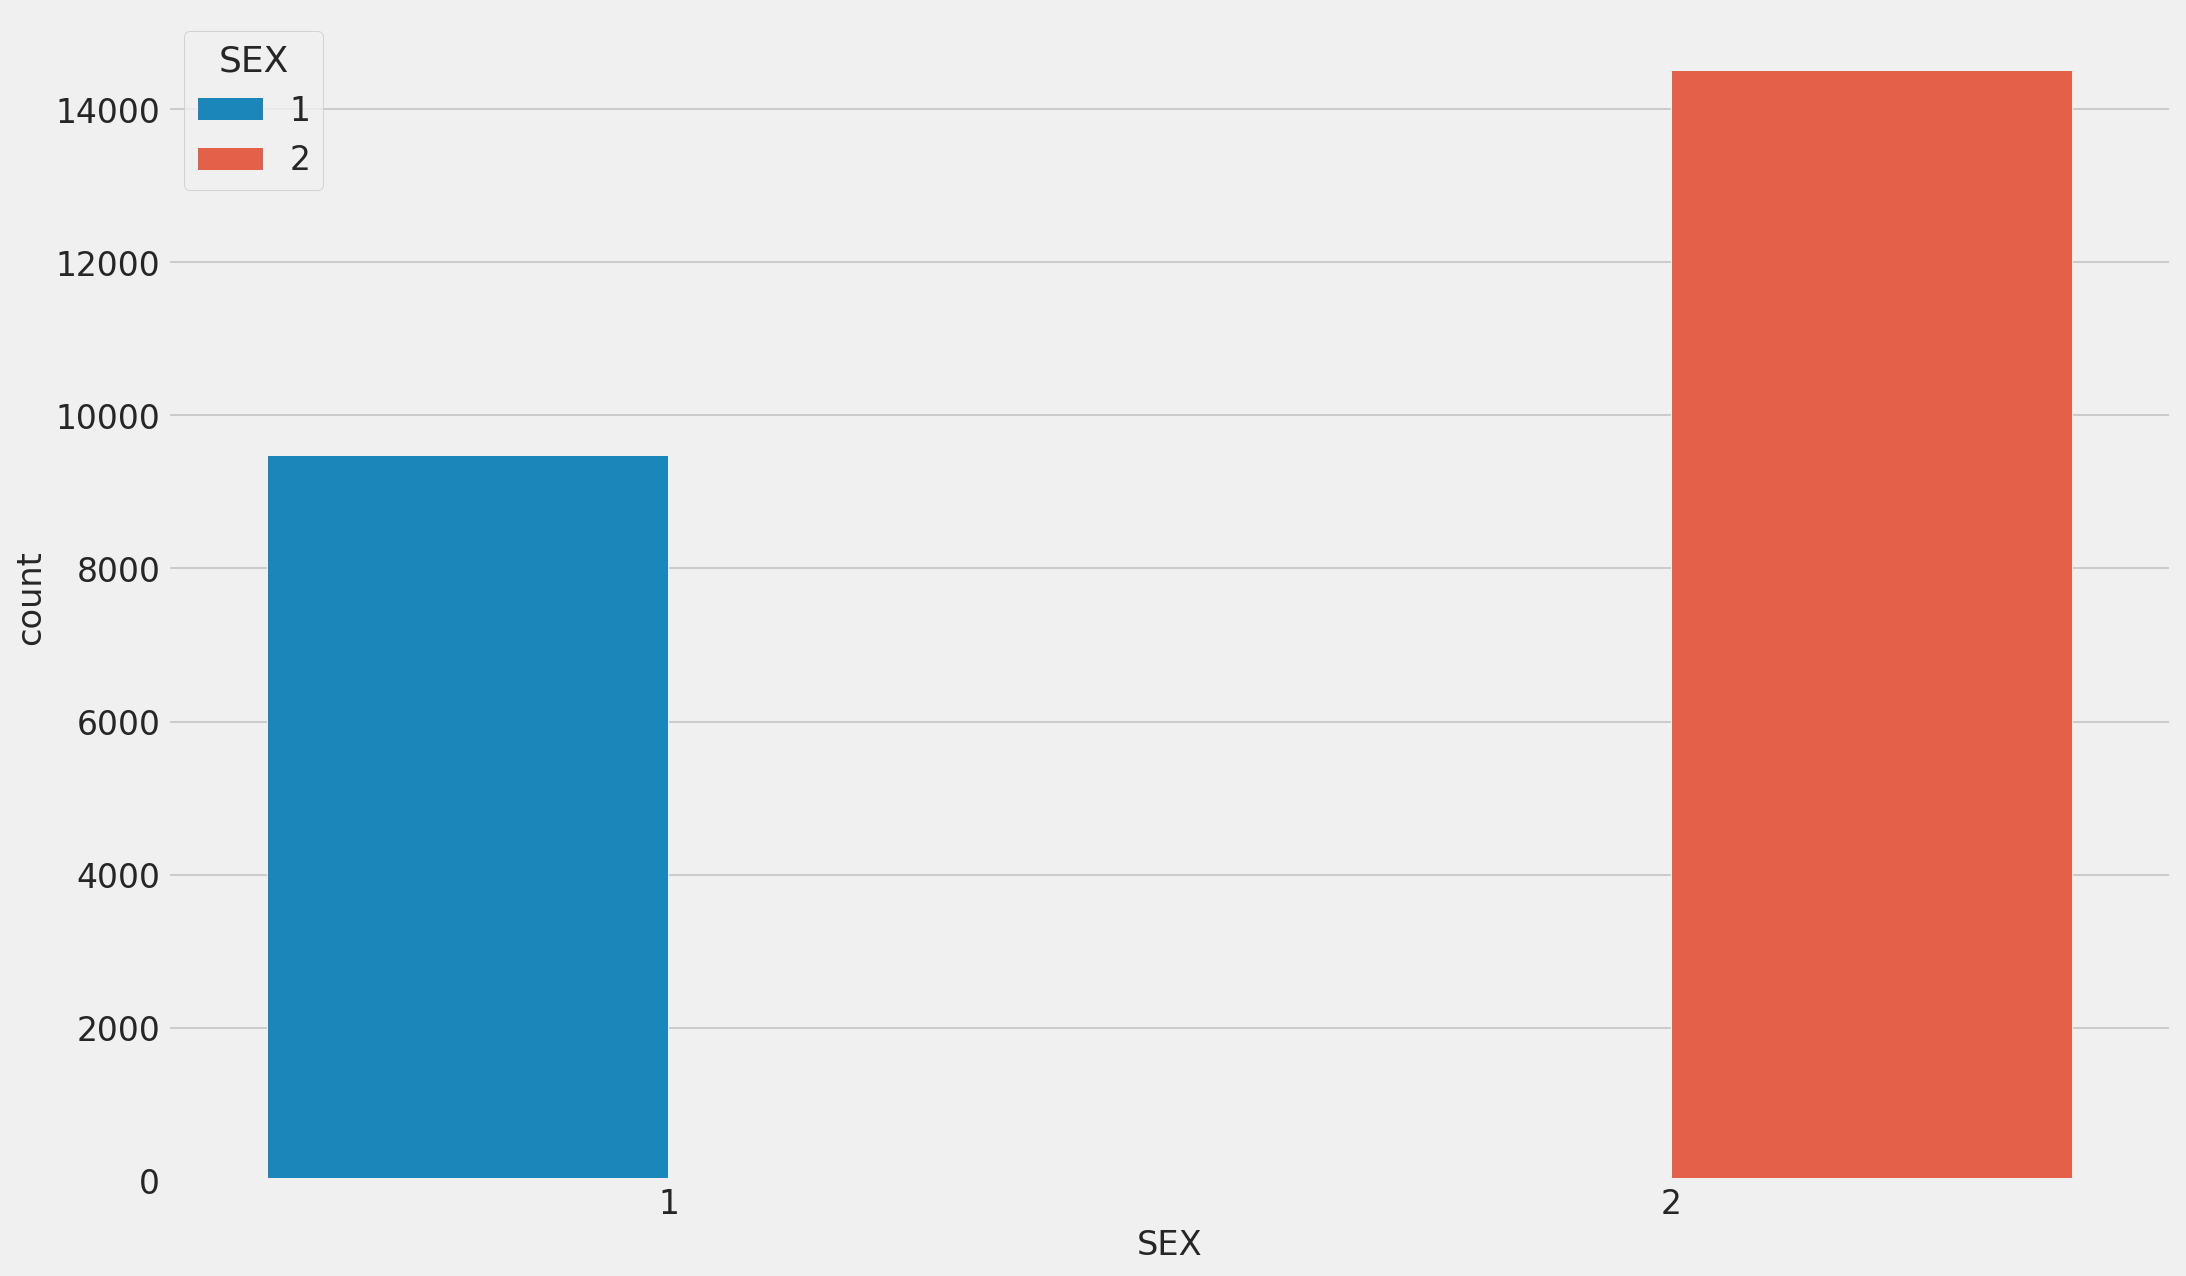

In [24]:
sns.countplot(x='SEX',data=X_train,hue='SEX')

<AxesSubplot:xlabel='def_payment', ylabel='count'>

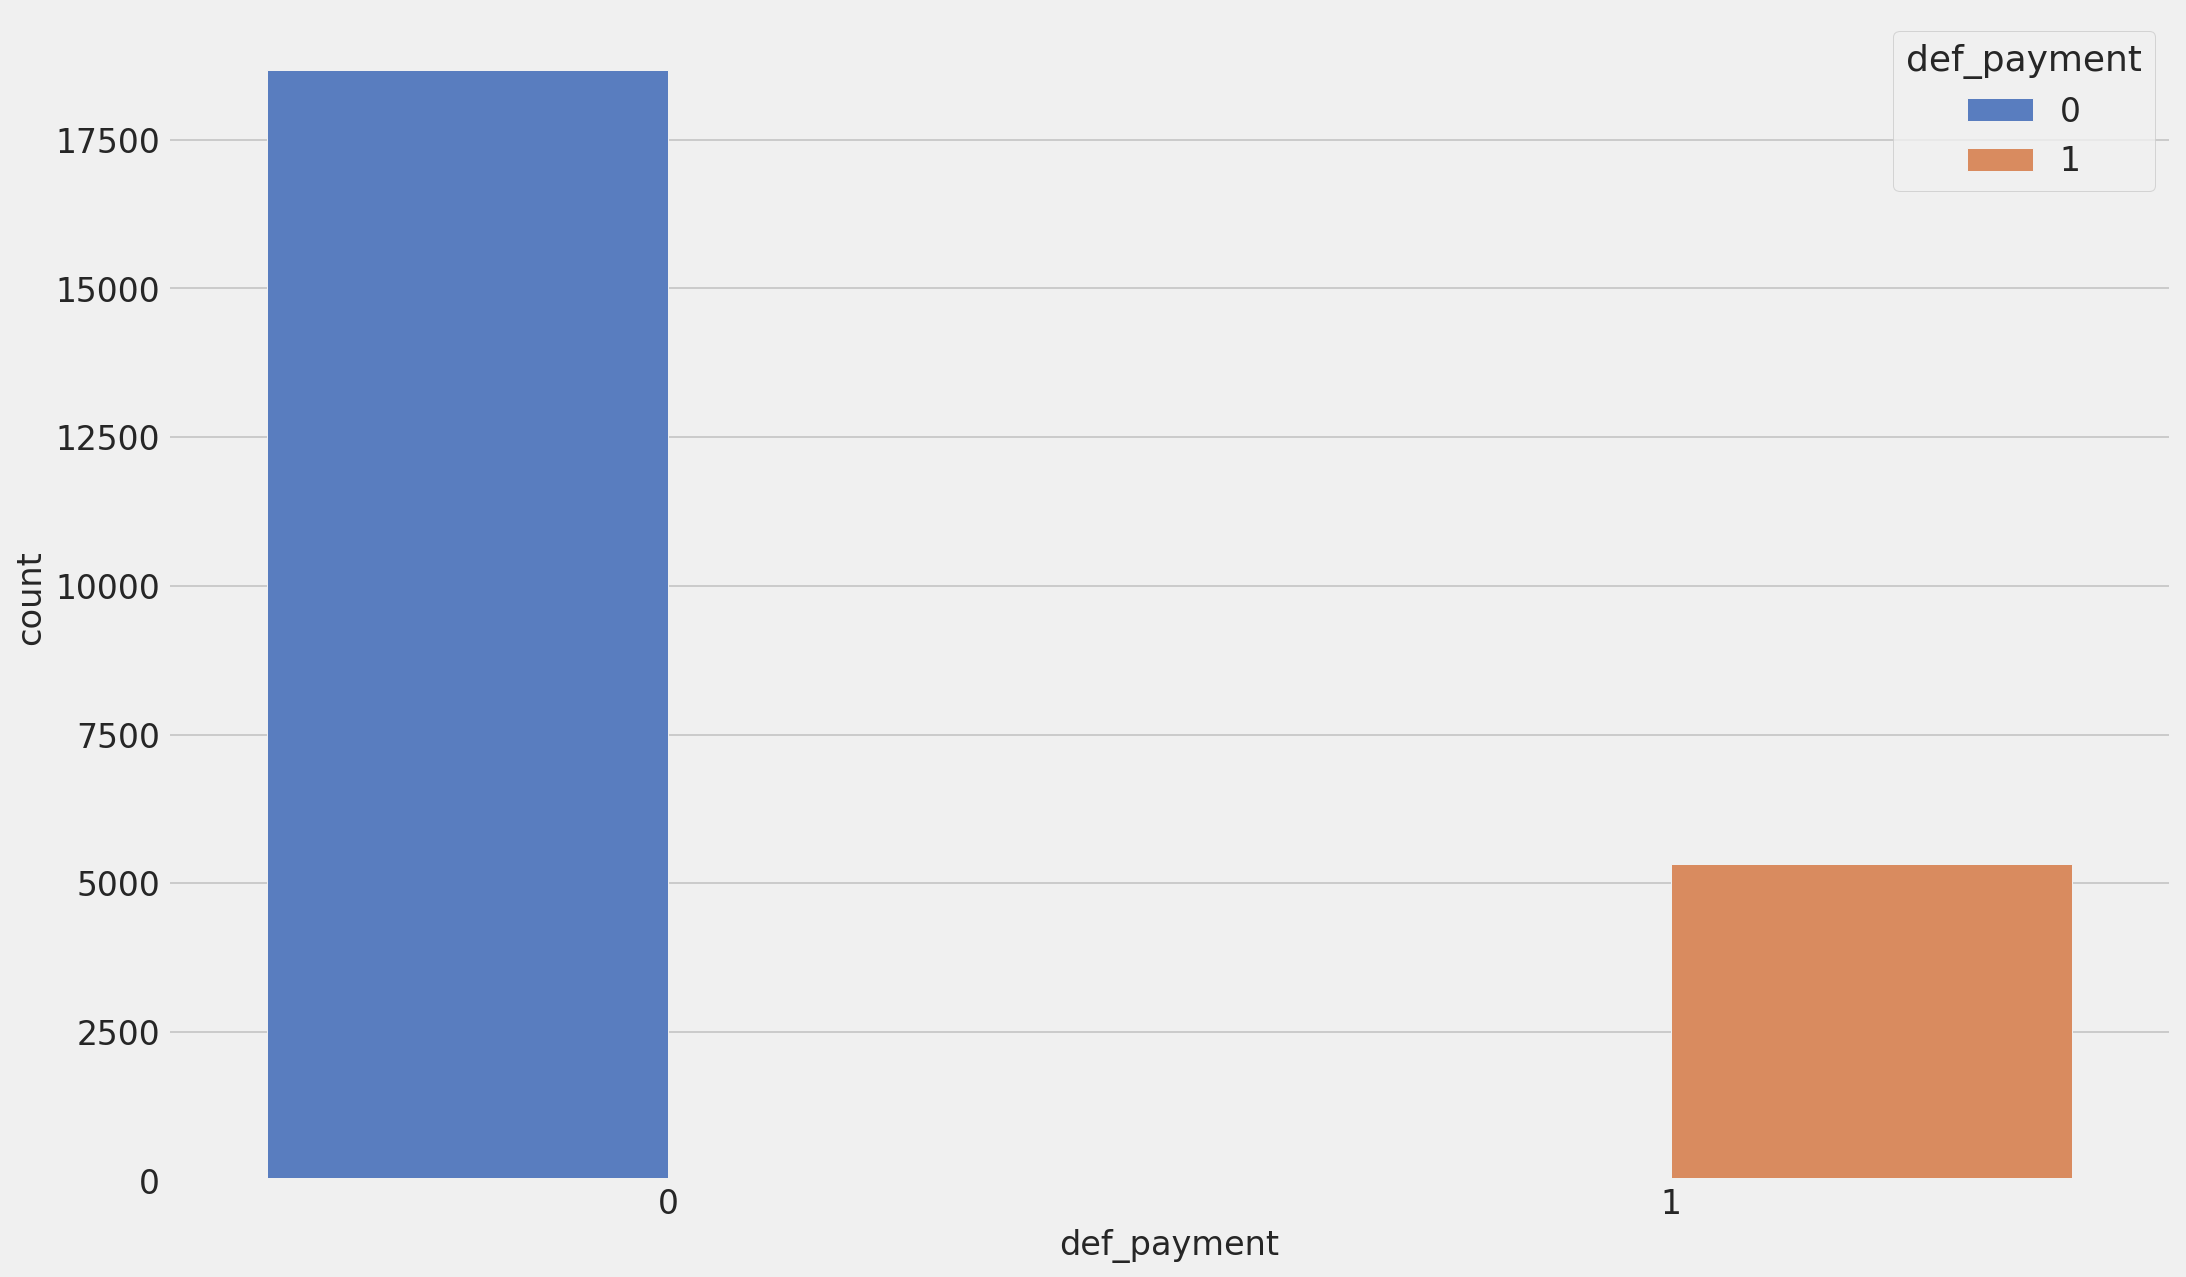

In [25]:
sns.countplot(x='def_payment', data=y_train, hue="def_payment", palette="muted")

In [26]:
# simple method to plot the features
def getFeatures(prefix):
    return [prefix+str(x) for x in range(1,7)]

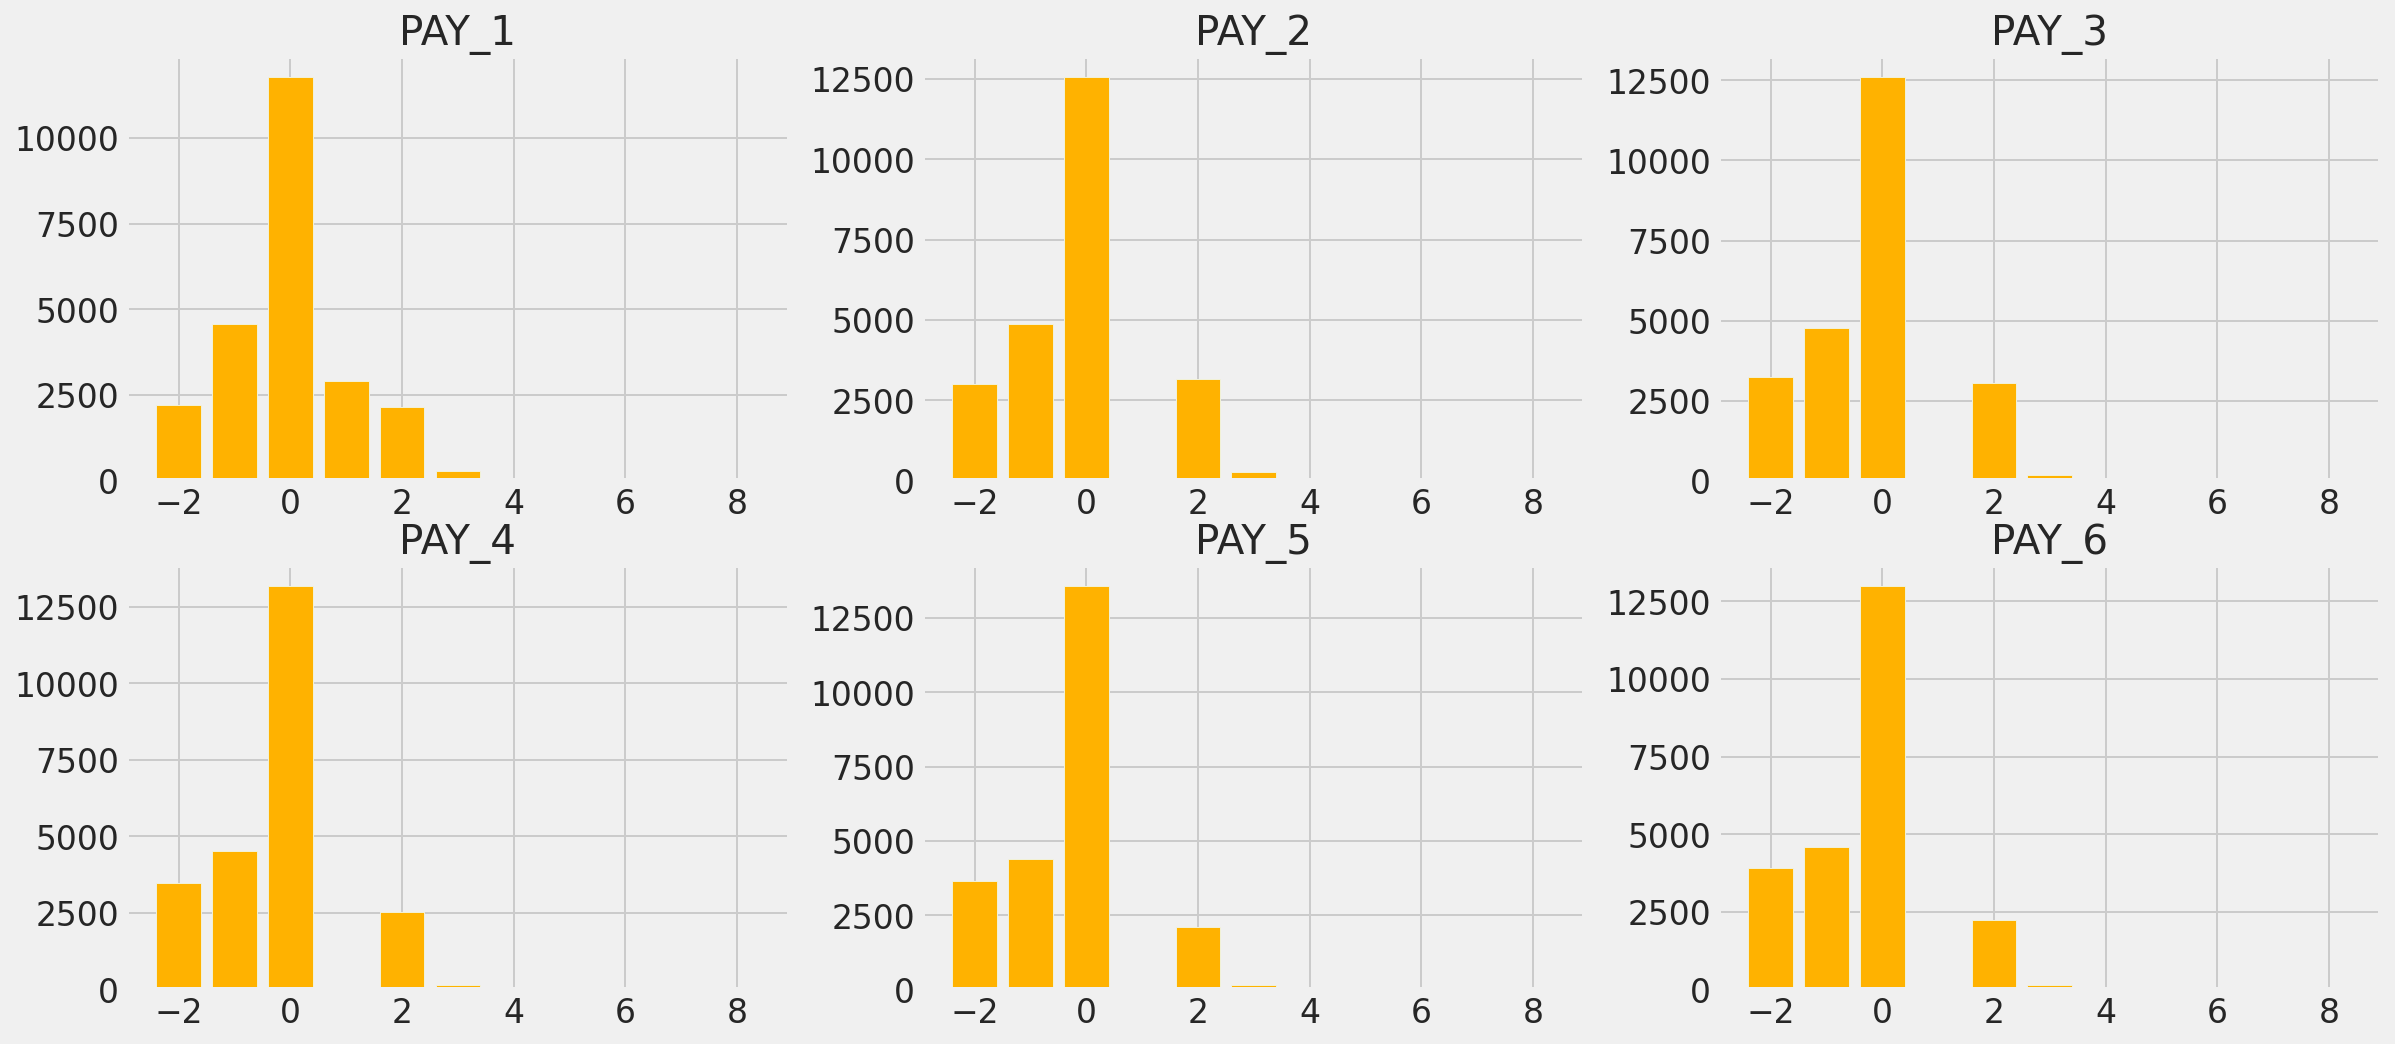

In [27]:
pay_status_columns = getFeatures('PAY_')
figure, ax = plt.subplots(2,3)
figure.set_size_inches(18,8)


for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = X_train[pay_status_columns[i]].value_counts()
    x = X_train[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='red')
    ax[row,col].bar(x.index, x, align='center', color='yellow', alpha=0.7)
    ax[row,col].set_title(pay_status_columns[i])
   


    
plt.show()

<AxesSubplot:xlabel='MARRIAGE', ylabel='AGE'>

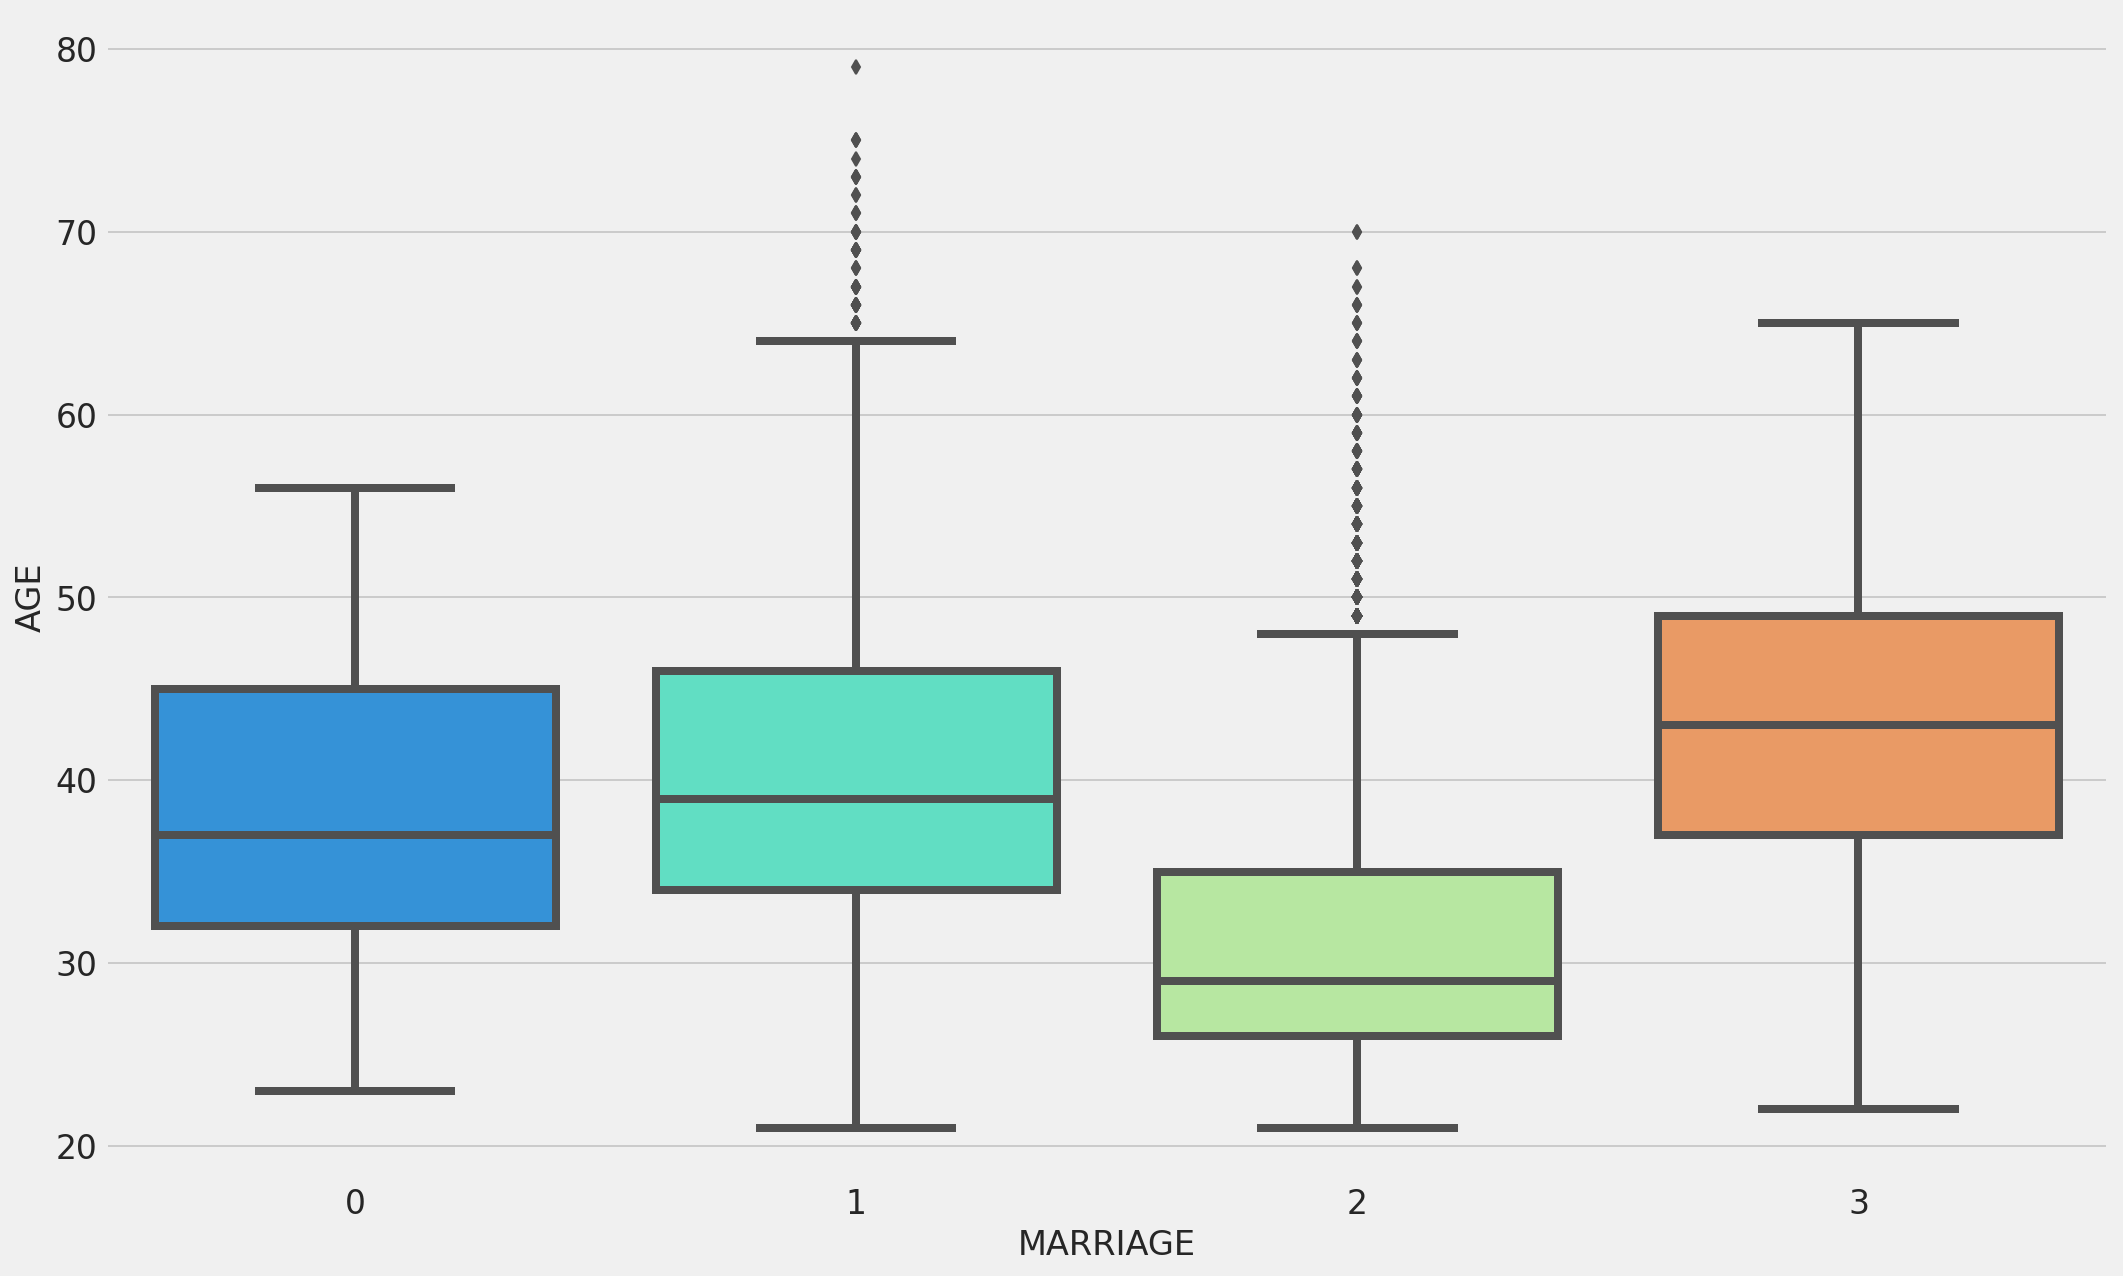

In [28]:
sns.boxplot(x='MARRIAGE',y='AGE',data=X_train,palette='rainbow')

<AxesSubplot:xlabel='EDUCATION', ylabel='AGE'>

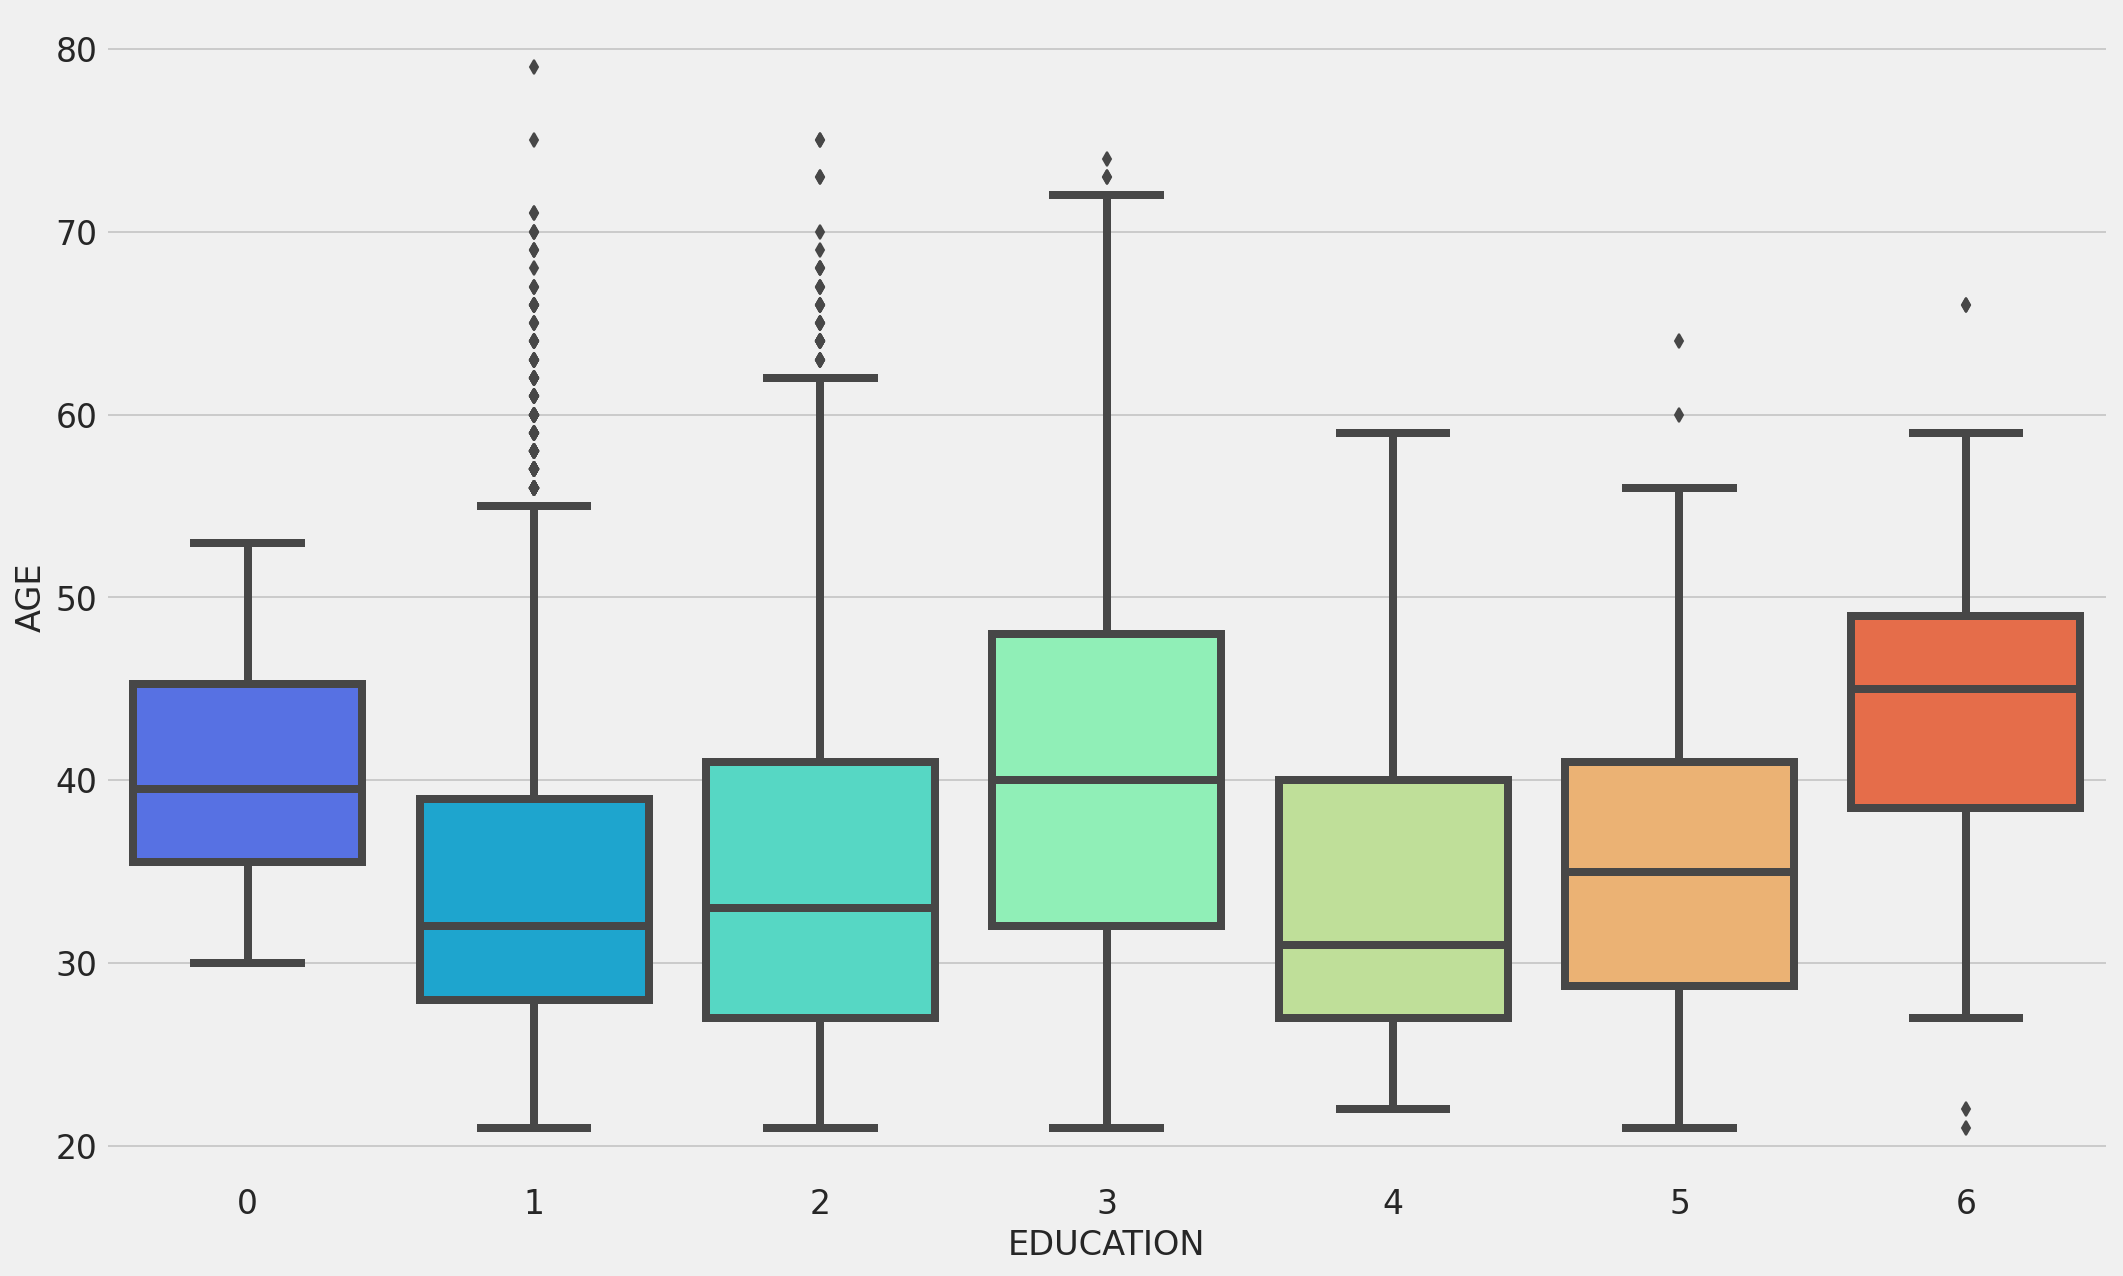

In [29]:
sns.boxplot(x='EDUCATION',y='AGE',data=X_train,palette='rainbow')

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

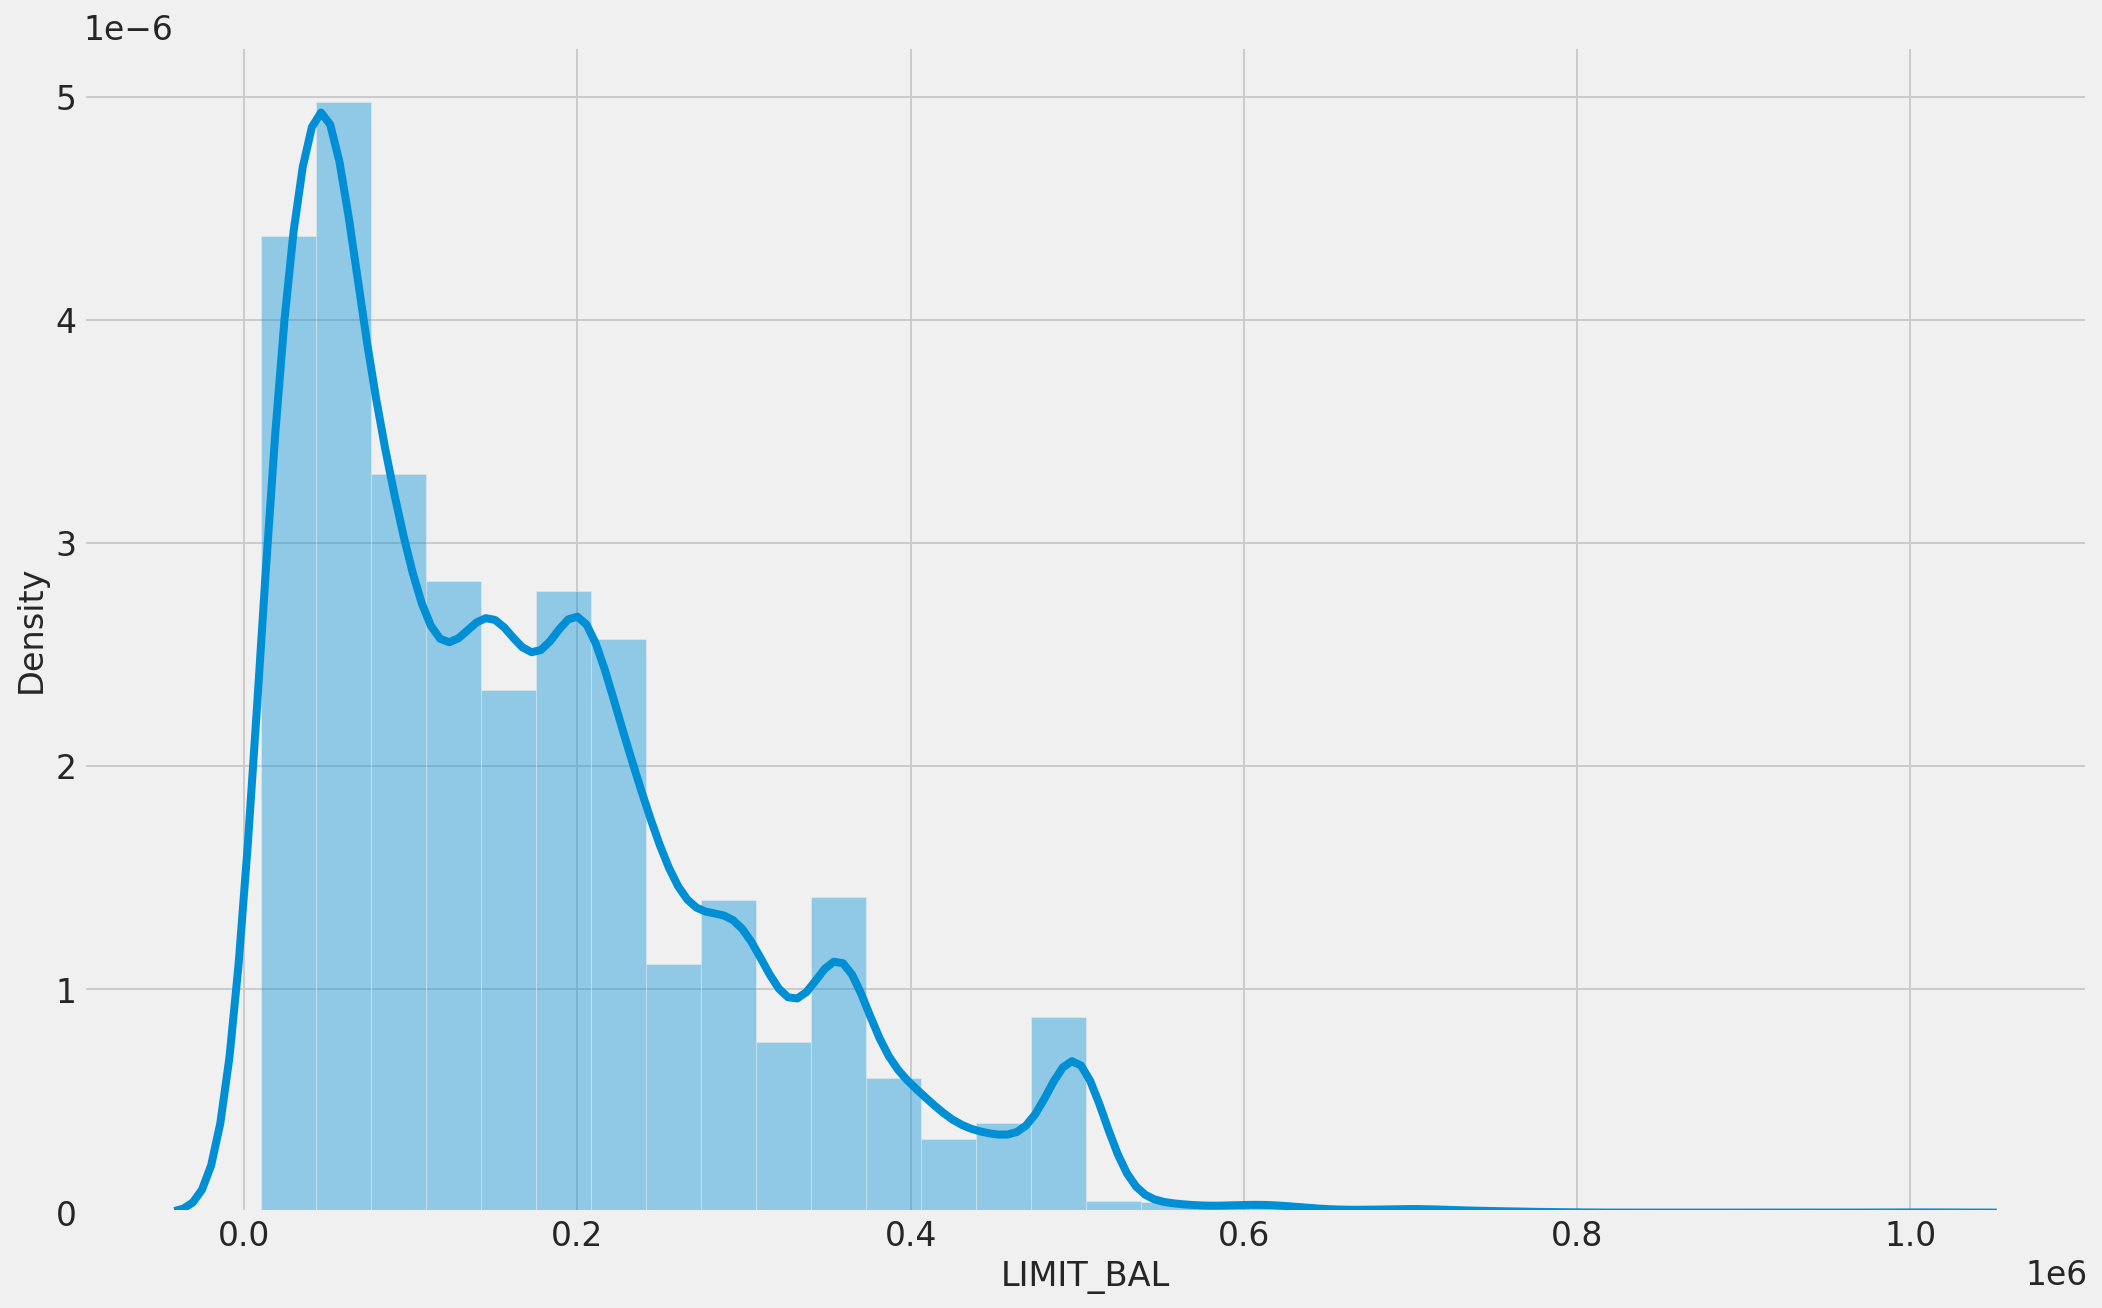

In [30]:
sns.distplot(X_train.LIMIT_BAL,kde=True,bins=30)

<AxesSubplot:>

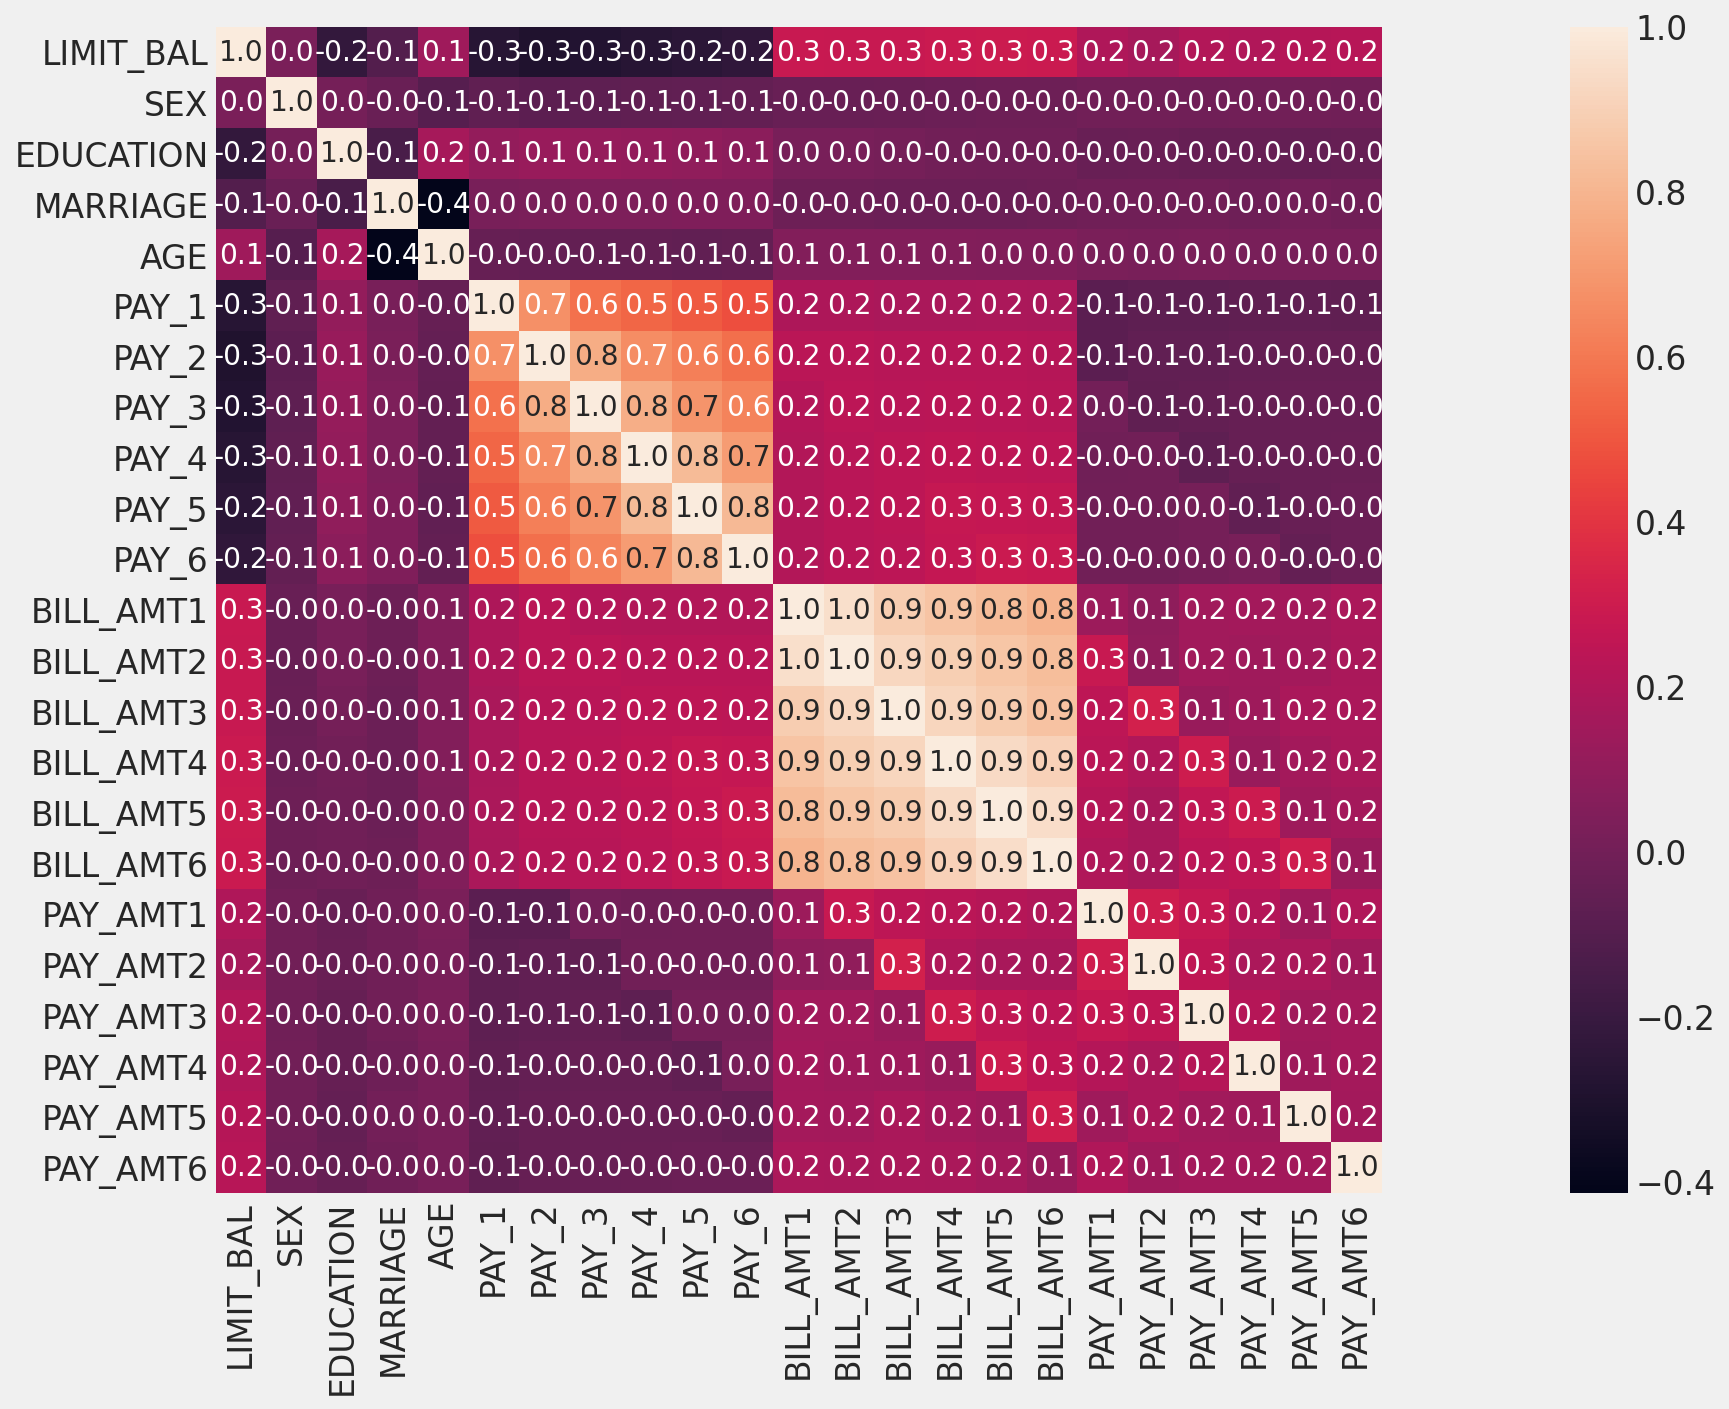

In [31]:
# Obeserving the correlation between features of dataset
correlation = X_train.corr()
plt.subplots(figsize=(30,10))
sns.heatmap( correlation, square=True, annot=True, fmt=".1f" )

## Preprocessing

In [32]:
fil = (X_train.EDUCATION == 5) | (X_train.EDUCATION == 6) | (X_train.EDUCATION == 0)
X_train.loc[fil, 'EDUCATION'] = 4
X_train.EDUCATION.value_counts()

2    11186
1     8481
3     3959
4      374
Name: EDUCATION, dtype: int64

In [33]:
fil = (X_test.EDUCATION == 5) | (X_test.EDUCATION == 6) | (X_test.EDUCATION == 0)
X_test.loc[fil, 'EDUCATION'] = 4
X_test.EDUCATION.value_counts()

2    2844
1    2104
3     958
4      94
Name: EDUCATION, dtype: int64

In [34]:
print(X_train['EDUCATION'].value_counts(dropna = False))
print(X_test['EDUCATION'].value_counts(dropna = False))

2    11186
1     8481
3     3959
4      374
Name: EDUCATION, dtype: int64
2    2844
1    2104
3     958
4      94
Name: EDUCATION, dtype: int64


In [35]:
X_train.loc[X_train.MARRIAGE == 0, 'MARRIAGE'] = 3
X_train.MARRIAGE.value_counts()

2    12747
1    10942
3      311
Name: MARRIAGE, dtype: int64

In [36]:
X_test.loc[X_test.MARRIAGE == 0, 'MARRIAGE'] = 3
X_test.MARRIAGE.value_counts()

2    3217
1    2717
3      66
Name: MARRIAGE, dtype: int64

In [37]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,4,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [38]:
X_train.tail()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
29803,50000.0,1,2,2,32,0,0,0,0,0,...,55739.0,55957.0,29238.0,6119.0,2000.0,3000.0,1591.0,72.0,1134.0,73421.0
5391,200000.0,1,1,2,37,2,2,2,2,2,...,168386.0,164182.0,169029.0,172084.0,13500.0,6000.0,0.0,7500.0,6000.0,4000.0
861,50000.0,1,1,2,26,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15796,70000.0,2,2,2,25,0,0,0,0,2,...,51152.0,35122.0,28633.0,28039.0,3000.0,2000.0,4500.0,1200.0,0.0,1200.0
23655,160000.0,2,2,1,36,-2,-2,-2,-2,-2,...,3640.0,2935.0,1603.0,14129.0,0.0,3660.0,3135.0,1650.0,14200.0,1500.0


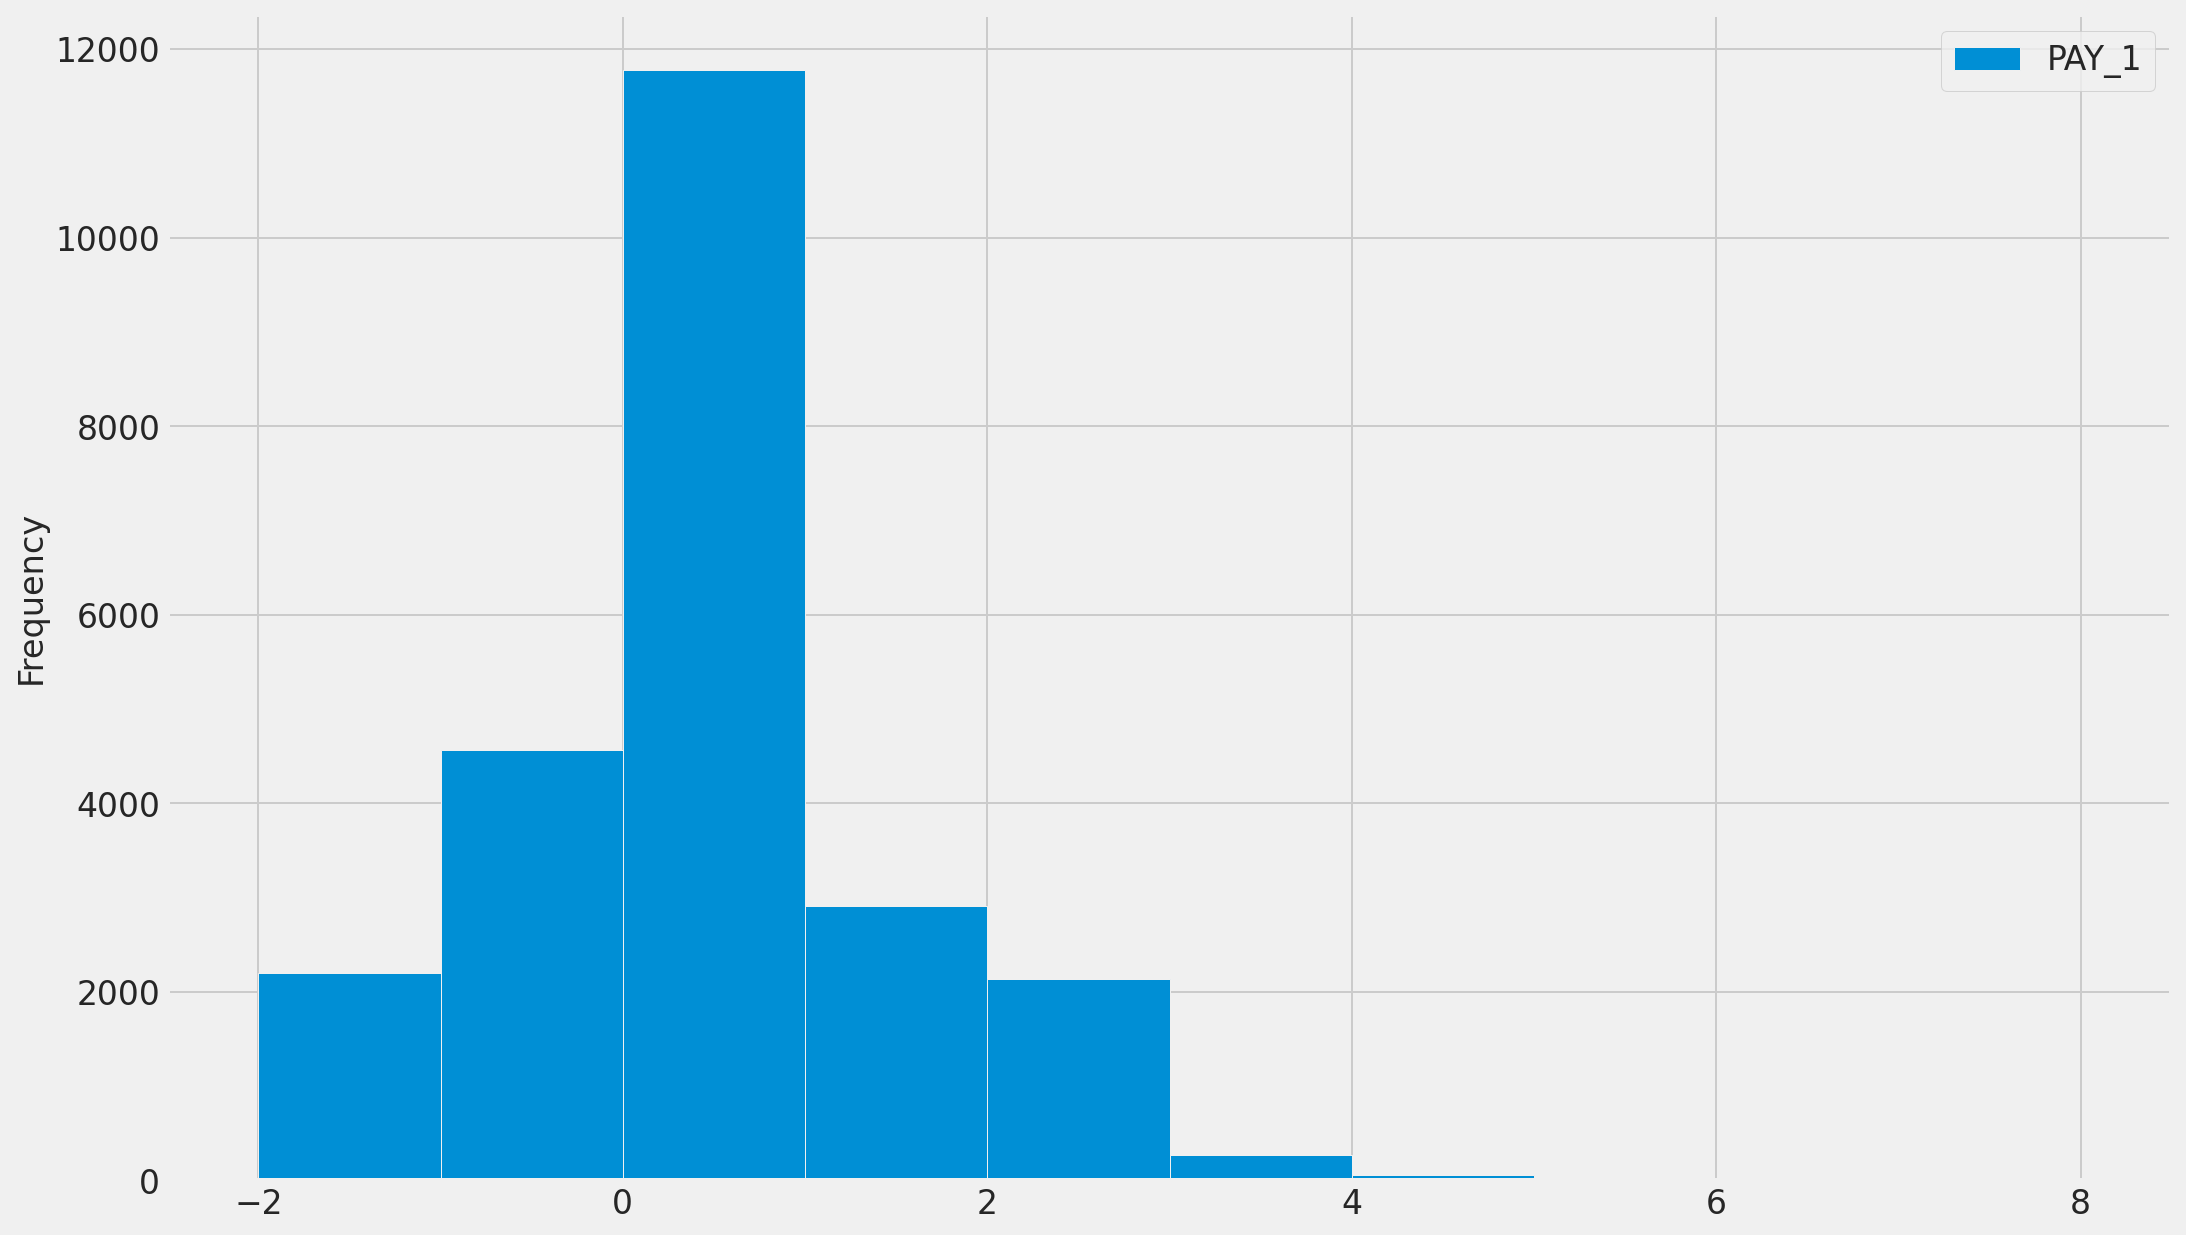

In [39]:
X_train.plot(y = 'PAY_1',kind='hist')
plt.legend()
plt.show()

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 21754 to 23655
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_1      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PA

In [41]:
X_train.SEX.nunique()

2

In [42]:
X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,5670.826542,5.961101e+03,5258.246500,4880.847125,4818.849250,5159.462125
std,17084.401034,2.428412e+04,18242.618988,16304.718844,15619.425964,17458.604219
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.615000e+02,390.000000,285.750000,240.750000,112.750000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,527143.000000


In [43]:
X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000
mean,50927.468417,48914.770500,4.675708e+04,43013.532167,40150.333000,38763.540458
std,73400.840274,70923.493353,6.926506e+04,64069.494705,60635.882129,59281.986863
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000
25%,3537.000000,2989.750000,2.699500e+03,2329.000000,1763.000000,1271.750000
50%,22321.500000,21140.500000,2.005000e+04,19010.000000,18085.000000,17108.500000
75%,66377.000000,63035.250000,5.952925e+04,53927.750000,50007.500000,49101.750000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


## Encoding of the categorical variable

In [44]:

categorical_vars = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
X_train[categorical_vars].astype(str)
X_test[categorical_vars].astype(str)
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,4,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [45]:
X_train.columns = X_train.columns.map(str.lower)
X_test.columns = X_test.columns.map(str.lower)

In [46]:
X_train.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,4,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


## Feature scaling

In [47]:
X_train.head(5)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000.0,2,2,2,24,0,0,0,0,0,...,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
252,30000.0,1,2,2,28,0,0,0,0,0,...,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22942,180000.0,2,4,1,44,0,0,-1,-1,-1,...,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
619,60000.0,1,1,2,25,0,0,0,0,0,...,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
17091,130000.0,2,2,2,25,0,0,0,0,0,...,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [48]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

X = X_train
y = np.array(y_train.def_payment.values)

transformer = make_column_transformer(
    (MinMaxScaler(), X_train.columns))
transformer.fit(X)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object'))])

In [49]:
# scaling
X = transformer.transform(X)

## Splitting the training and test data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape

(19200, 23)

# Neural Network Models

## 1. Neural Network with 3 layers

In [51]:
# The following method will help us plotting the F1-Score results
def plot_f1(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('F1')
  plt.plot(hist['epoch'], hist['loss'],
            label='Train F1')
  plt.plot(hist['epoch'], hist['val_loss'],
            label = 'Val F1')
  plt.legend()
  plt.show()

Epoch 1/50
480/480 [==============================] - 1s 2ms/step - loss: 0.5626 - accuracy: 0.7491 - val_loss: 0.5272 - val_accuracy: 0.7708
Epoch 2/50
480/480 [==============================] - 1s 2ms/step - loss: 0.5004 - accuracy: 0.7783 - val_loss: 0.4967 - val_accuracy: 0.7737
Epoch 3/50
480/480 [==============================] - 2s 3ms/step - loss: 0.4790 - accuracy: 0.7923 - val_loss: 0.4839 - val_accuracy: 0.7896
Epoch 4/50
480/480 [==============================] - 2s 4ms/step - loss: 0.4703 - accuracy: 0.8025 - val_loss: 0.4772 - val_accuracy: 0.7948
Epoch 5/50
480/480 [==============================] - 2s 4ms/step - loss: 0.4656 - accuracy: 0.8062 - val_loss: 0.4722 - val_accuracy: 0.8000
Epoch 6/50
480/480 [==============================] - 2s 3ms/step - loss: 0.4624 - accuracy: 0.8075 - val_loss: 0.4692 - val_accuracy: 0.7995
Epoch 7/50
480/480 [==============================] - 2s 4ms/step - loss: 0.4597 - accuracy: 0.8094 - val_loss: 0.4659 - val_accuracy: 0.8073
Epoch 

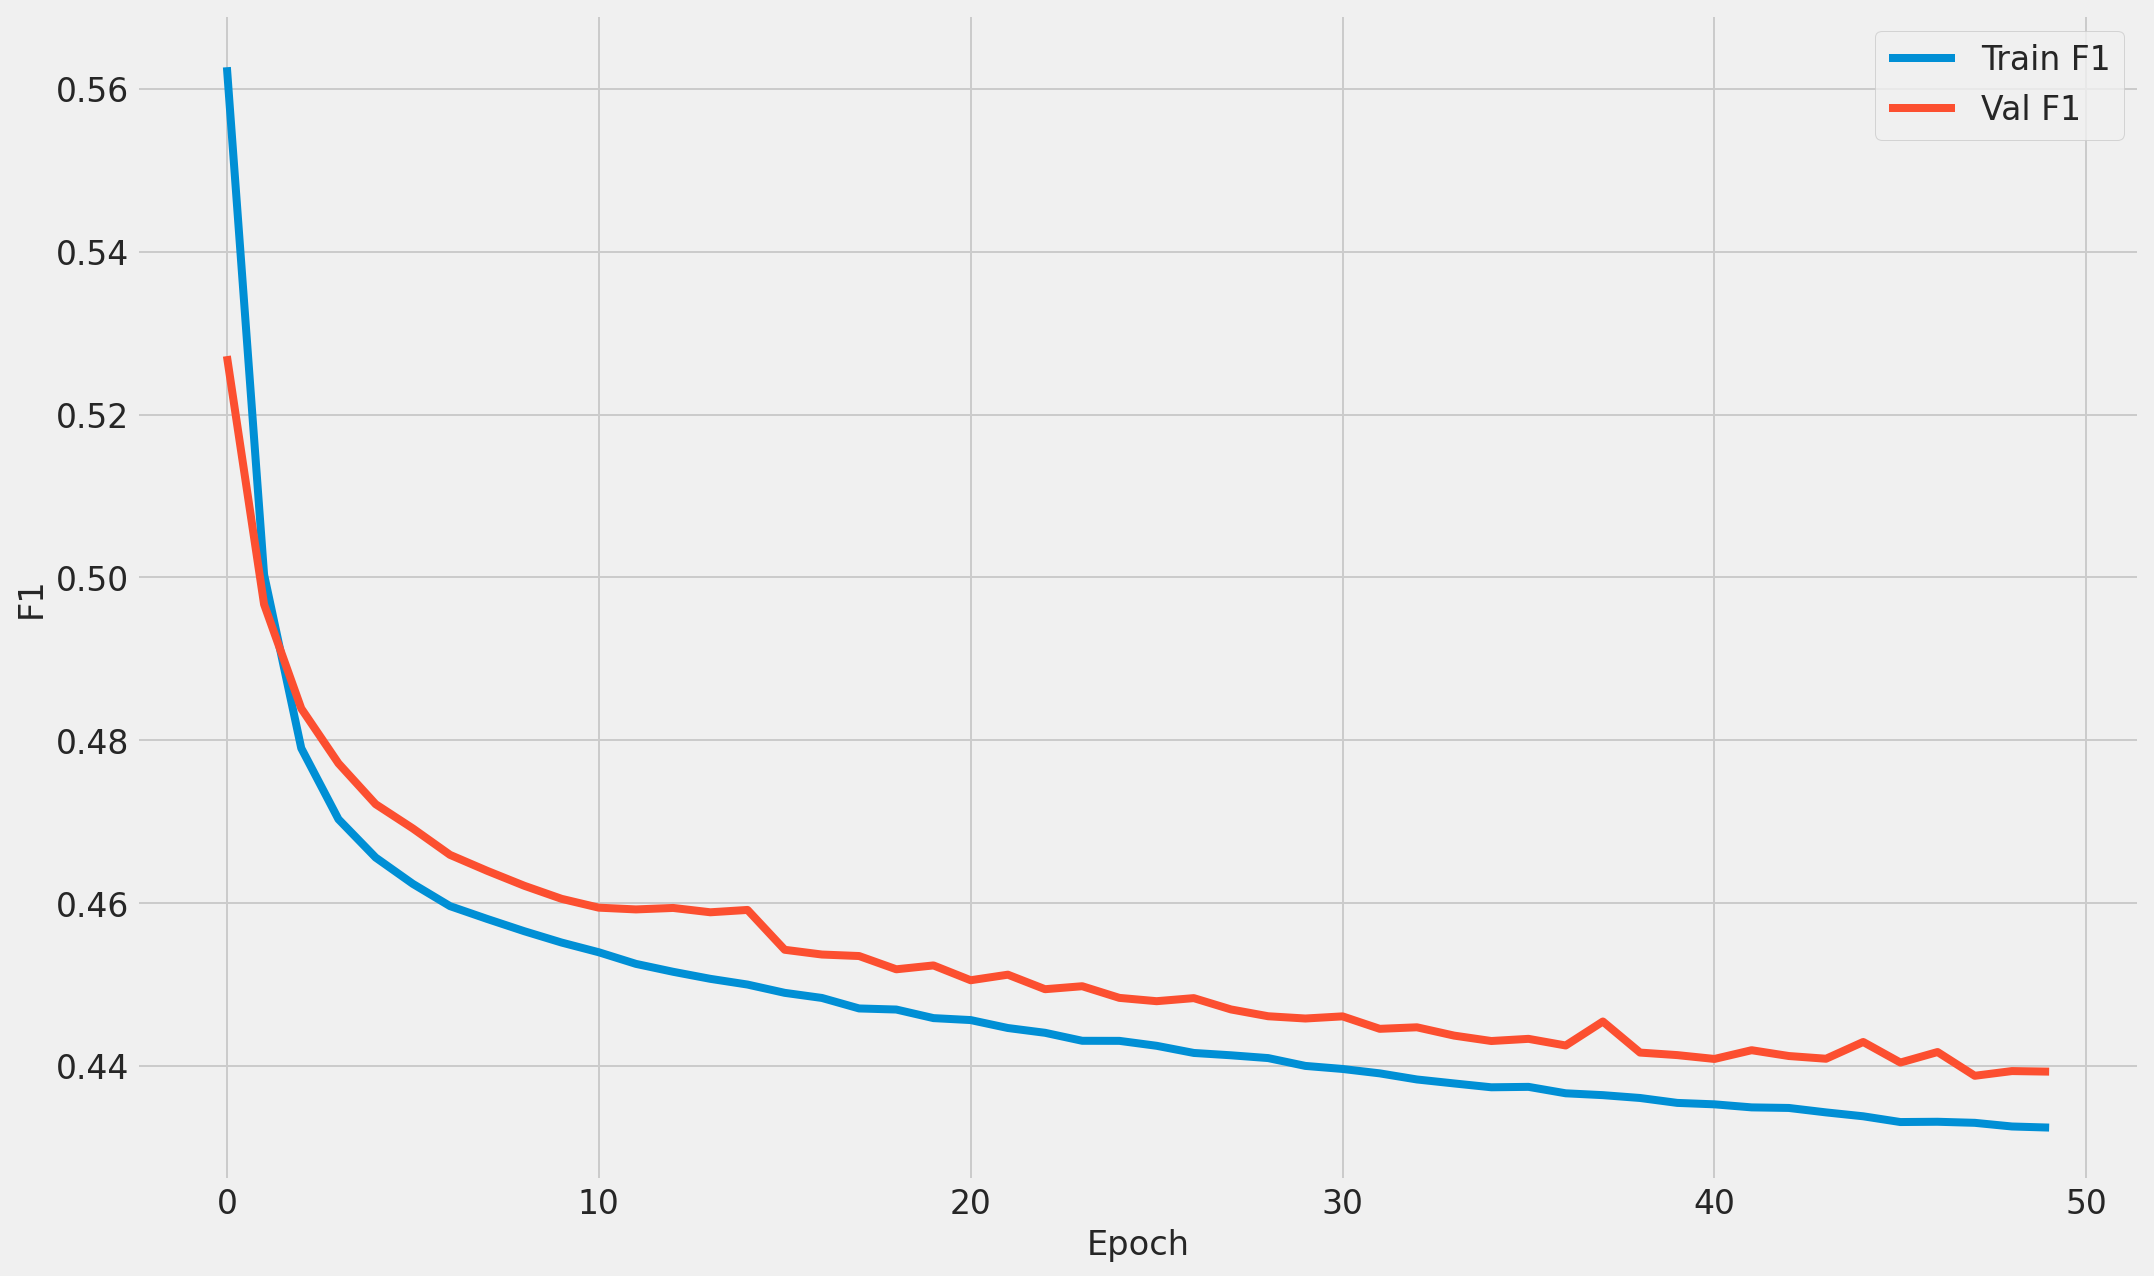

In [52]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(units=32, activation="relu", input_shape=[X_train.shape[1]]))
model1.add(keras.layers.Dense(units=64, activation="relu"))
model1.add(keras.layers.Dense(units=128, activation='relu'))

model1.add(keras.layers.Dense(1, activation="sigmoid"))

model1.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=10
)

history = model1.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=50,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## 2. Neural Network with SGD Optimizer (4-layers)

Epoch 1/100
240/240 [==============================] - 1s 4ms/step - loss: 0.6763 - accuracy: 0.7178 - val_loss: 0.6675 - val_accuracy: 0.7555
Epoch 2/100
240/240 [==============================] - 1s 4ms/step - loss: 0.6588 - accuracy: 0.7710 - val_loss: 0.6516 - val_accuracy: 0.7688
Epoch 3/100
240/240 [==============================] - 1s 4ms/step - loss: 0.6434 - accuracy: 0.7779 - val_loss: 0.6375 - val_accuracy: 0.7708
Epoch 4/100
240/240 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.7780 - val_loss: 0.6250 - val_accuracy: 0.7708
Epoch 5/100
240/240 [==============================] - 1s 4ms/step - loss: 0.6176 - accuracy: 0.7781 - val_loss: 0.6141 - val_accuracy: 0.7708
Epoch 6/100
240/240 [==============================] - 1s 5ms/step - loss: 0.6069 - accuracy: 0.7781 - val_loss: 0.6044 - val_accuracy: 0.7708
Epoch 7/100
240/240 [==============================] - 1s 4ms/step - loss: 0.5974 - accuracy: 0.7781 - val_loss: 0.5959 - val_accuracy: 0.7708

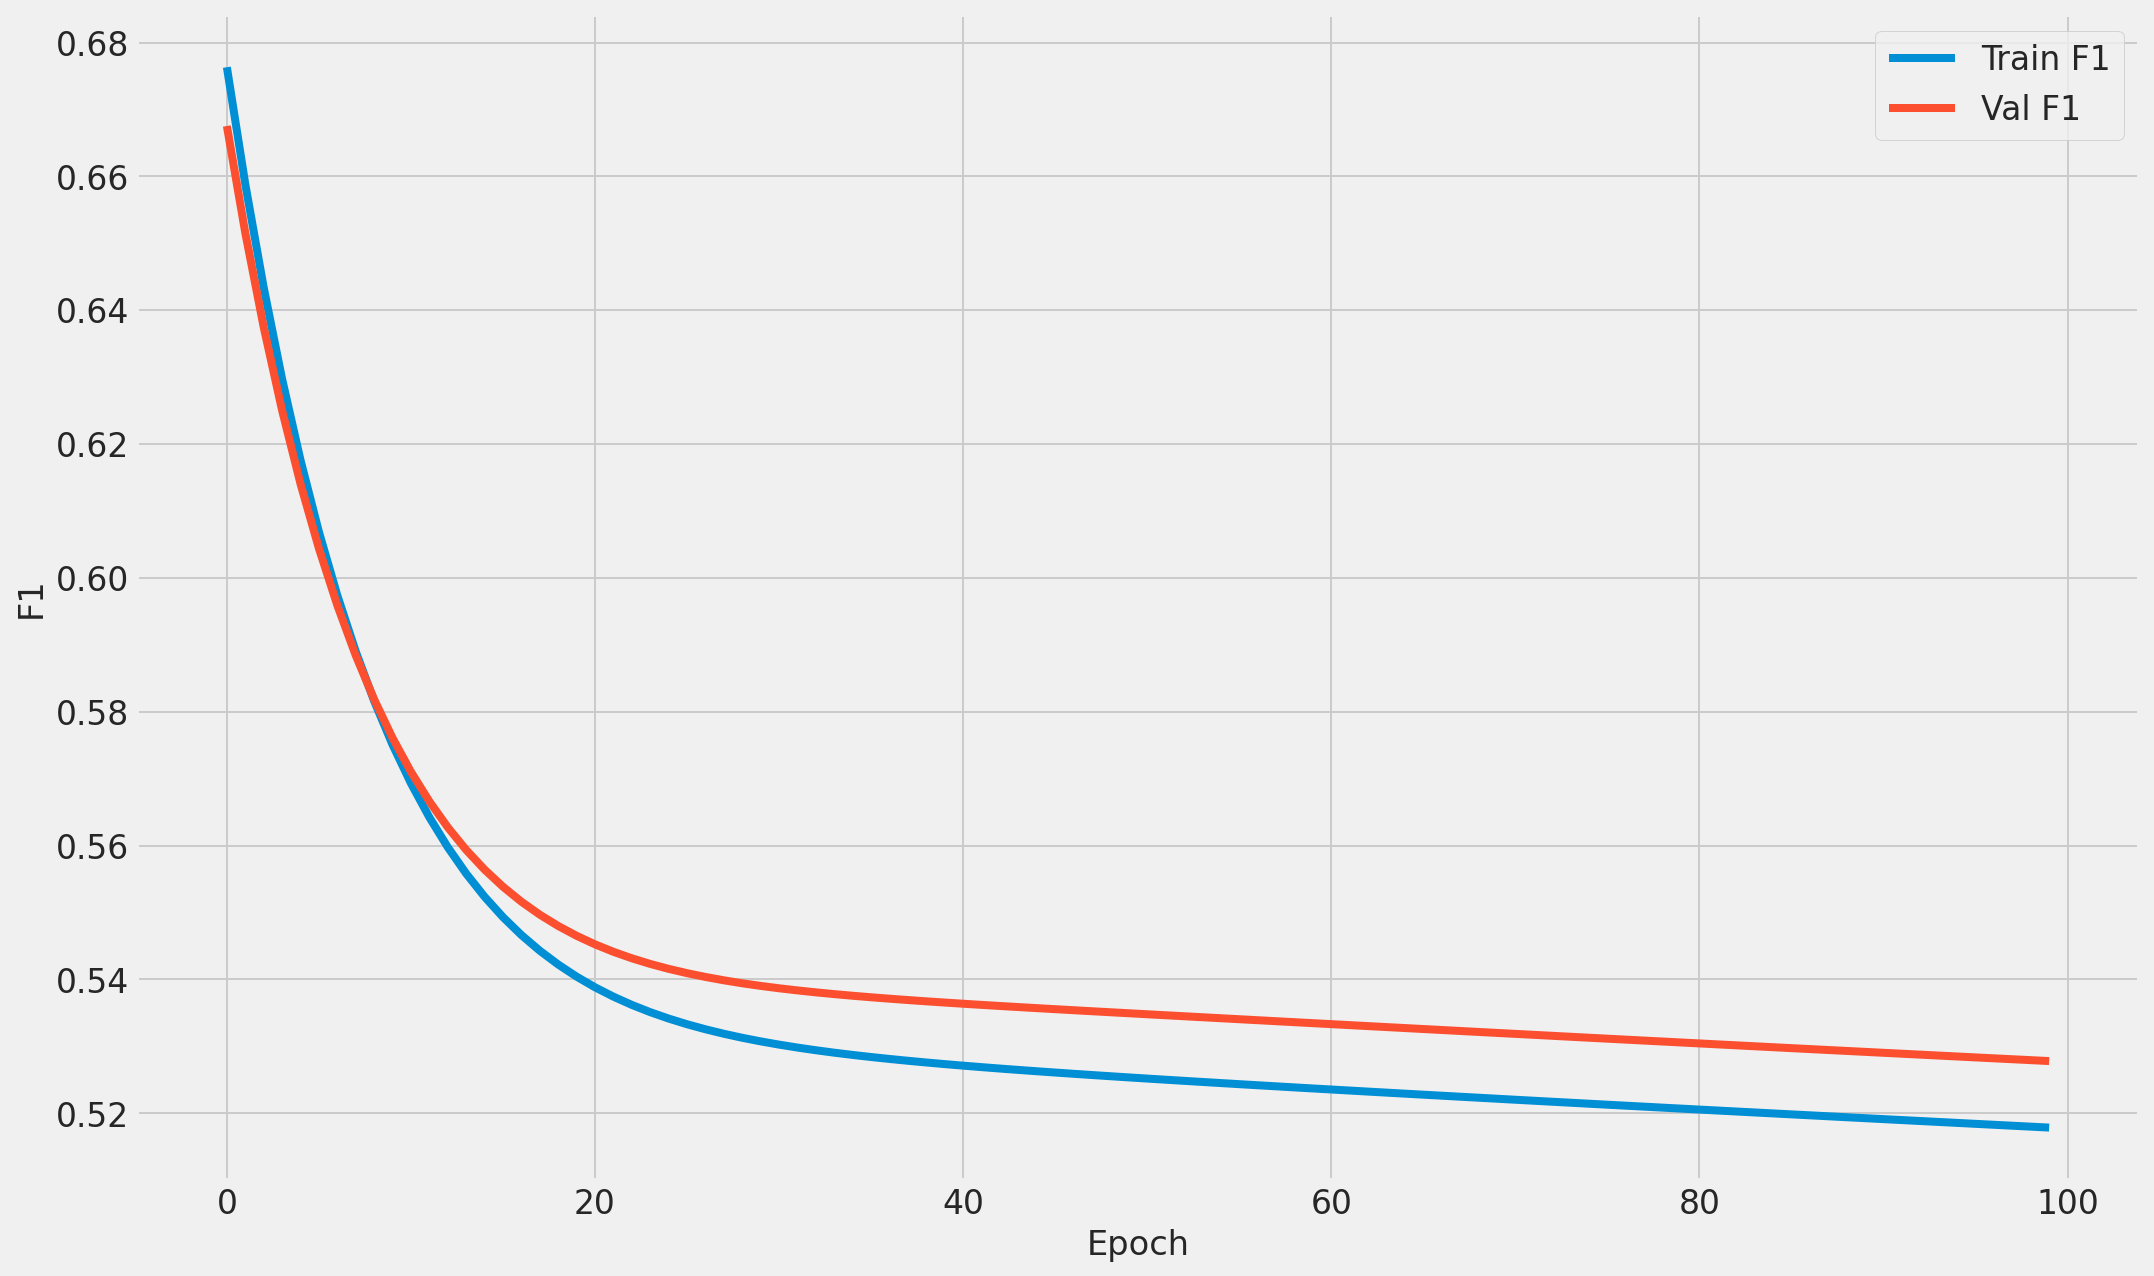

In [53]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(units=32, activation="relu", input_shape=[X_train.shape[1]]))
model2.add(keras.layers.Dense(units=64, activation="selu"))
model2.add(keras.layers.Dense(units=128, activation="selu"))
model2.add(keras.layers.Dense(units=256, activation="relu"))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.compile(
    optimizer=keras.optimizers.SGD(0.0001),
    loss='binary_crossentropy', 
    metrics = ['accuracy'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=10
)

history = model2.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## 3. Neural Network with 4 layers and Adagrad Optimizer

Epoch 1/100
240/240 [==============================] - 1s 5ms/step - loss: 0.6084 - accuracy: 0.7406 - val_loss: 0.5578 - val_accuracy: 0.7708
Epoch 2/100
240/240 [==============================] - 1s 5ms/step - loss: 0.5399 - accuracy: 0.7781 - val_loss: 0.5417 - val_accuracy: 0.7708
Epoch 3/100
240/240 [==============================] - 1s 6ms/step - loss: 0.5309 - accuracy: 0.7781 - val_loss: 0.5371 - val_accuracy: 0.7708
Epoch 4/100
240/240 [==============================] - 1s 5ms/step - loss: 0.5263 - accuracy: 0.7781 - val_loss: 0.5330 - val_accuracy: 0.7708
Epoch 5/100
240/240 [==============================] - 1s 6ms/step - loss: 0.5220 - accuracy: 0.7781 - val_loss: 0.5287 - val_accuracy: 0.7708
Epoch 6/100
240/240 [==============================] - 1s 5ms/step - loss: 0.5178 - accuracy: 0.7781 - val_loss: 0.5244 - val_accuracy: 0.7708
Epoch 7/100
240/240 [==============================] - 1s 5ms/step - loss: 0.5136 - accuracy: 0.7781 - val_loss: 0.5200 - val_accuracy: 0.7708

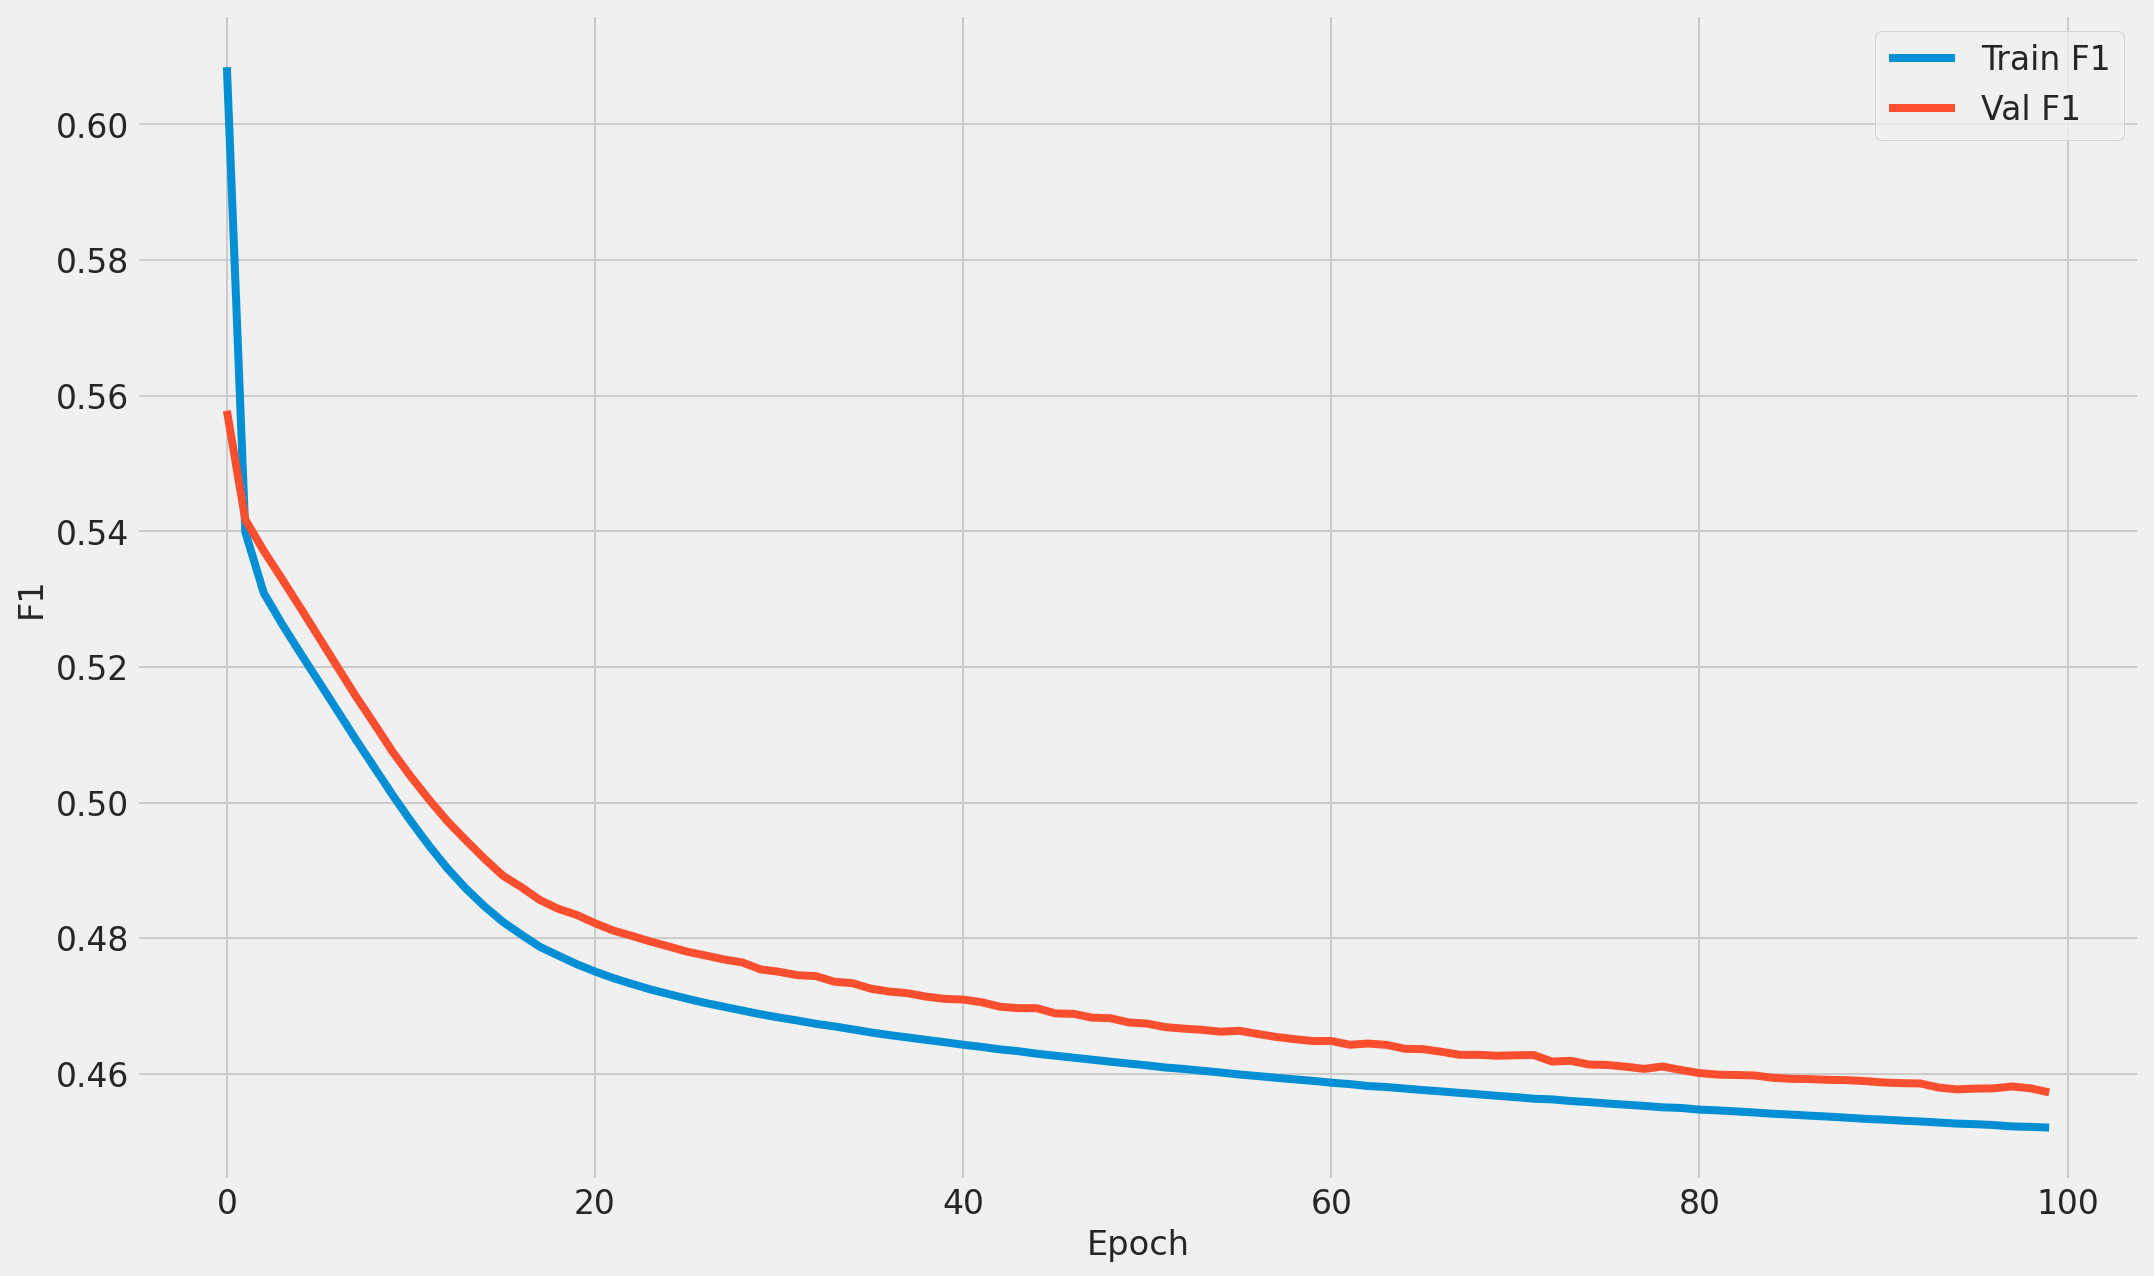

In [54]:
model3 = keras.Sequential()
model3.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model3.add(keras.layers.Dense(units=128, activation="linear"))
model3.add(keras.layers.Dense(units=256, activation="selu"))
model3.add(keras.layers.Dense(units=512, activation="relu"))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.compile(
    optimizer=keras.optimizers.Adagrad(0.001),
    loss='binary_crossentropy', 
    metrics = ['accuracy'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=10
)

history = model3.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## 4. Neural Network with dropout regularization at 30%

Epoch 1/100
240/240 [==============================] - 1s 5ms/step - loss: 0.6727 - accuracy: 0.7001 - val_loss: 0.6698 - val_accuracy: 0.7708
Epoch 2/100
240/240 [==============================] - 1s 5ms/step - loss: 0.6629 - accuracy: 0.7494 - val_loss: 0.6607 - val_accuracy: 0.7708
Epoch 3/100
240/240 [==============================] - 1s 5ms/step - loss: 0.6537 - accuracy: 0.7695 - val_loss: 0.6519 - val_accuracy: 0.7708
Epoch 4/100
240/240 [==============================] - 2s 7ms/step - loss: 0.6448 - accuracy: 0.7762 - val_loss: 0.6433 - val_accuracy: 0.7708
Epoch 5/100
240/240 [==============================] - 2s 7ms/step - loss: 0.6358 - accuracy: 0.7775 - val_loss: 0.6351 - val_accuracy: 0.7708
Epoch 6/100
240/240 [==============================] - 2s 7ms/step - loss: 0.6269 - accuracy: 0.7779 - val_loss: 0.6273 - val_accuracy: 0.7708
Epoch 7/100
240/240 [==============================] - 2s 9ms/step - loss: 0.6194 - accuracy: 0.7781 - val_loss: 0.6199 - val_accuracy: 0.7708

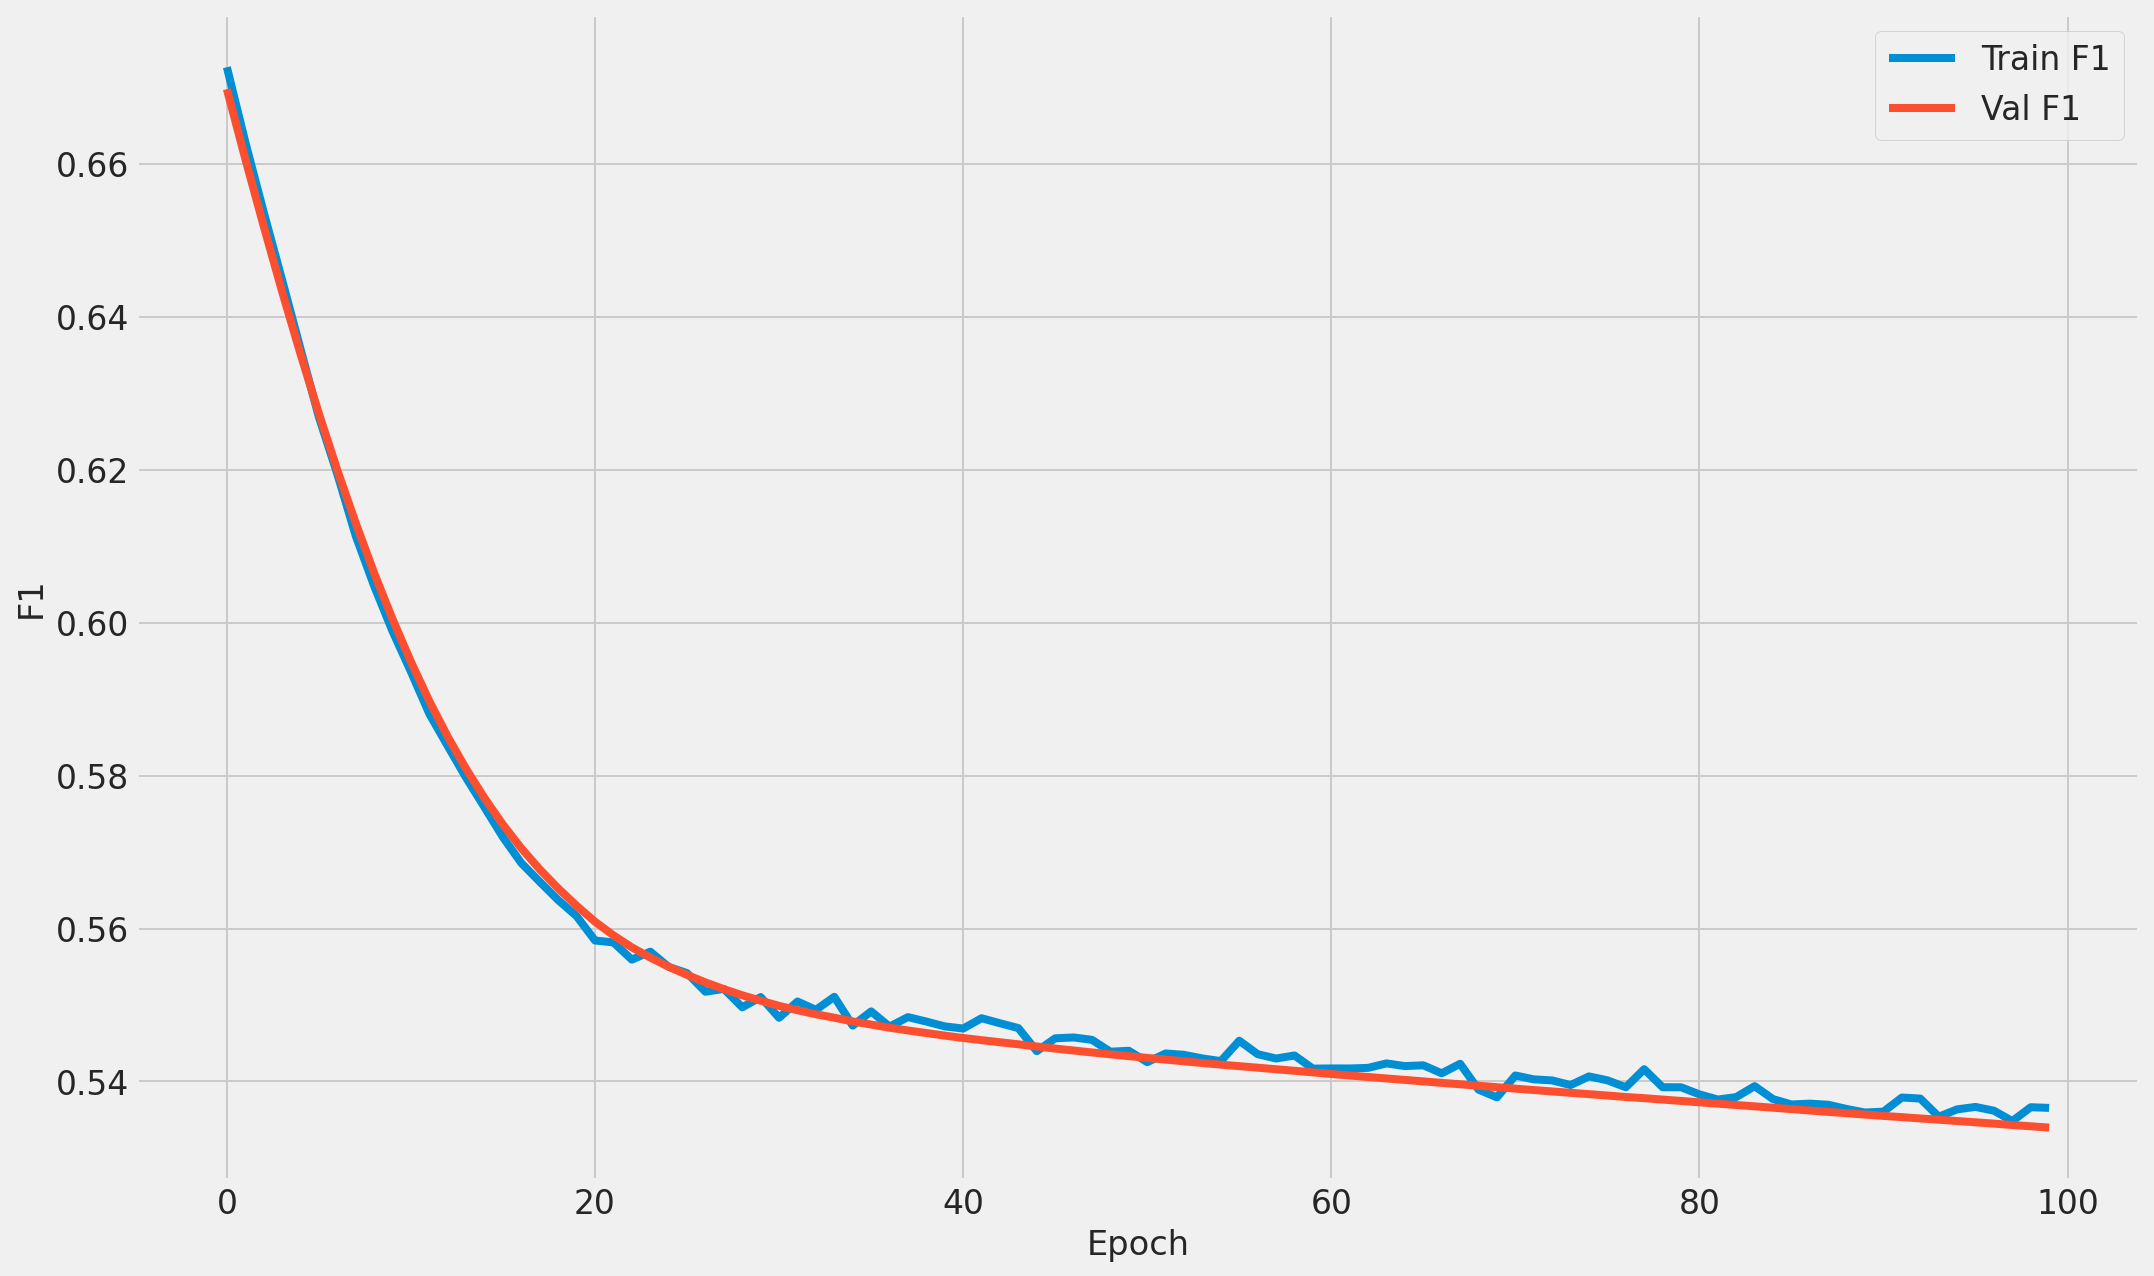

In [55]:
model4 = keras.Sequential()
model4.add(keras.layers.Dropout(0.3, input_shape=(X_train.shape[1],)))
model4.add(keras.layers.Dense(units=128, activation="relu"))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(units=256, activation="relu"))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(units=512, activation="relu"))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.compile(
    optimizer=keras.optimizers.Adadelta(0.001),
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  mode="min",
  patience=15
)

history = model4.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_f1(history)

## Model Evaluation

In [56]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# We add the predicted score to a file text
f = open("Mirko_Lantieri_858278_score2.txt", "a")

In [57]:
a = np.asarray(model1.predict(X_test))
f.write(f"{a}\n")

90

In [58]:
a = np.asarray(model2.predict(X_test))
f.write(f"{a}\n")

90

In [59]:
a = np.asarray(model3.predict(X_test))
f.write(f"{a}\n")

90

In [60]:
a = np.asarray(model4.predict(X_test))
f.write(f"{a}\n")

90

In [61]:
f.close()


## Metrics evaluation Model 1

In [62]:
y_pred = np.round(model1.predict(X_test))
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [63]:
results = pd.DataFrame([['Logistic Regression', acc,prec,recall, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.822083,0.651007,0.375242,0.476074,0.660005


## Metrics evaluation Model 2

In [64]:
y_pred = np.round(model2.predict(X_test))
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [65]:
results = pd.DataFrame([['Logistic Regression', acc,prec,recall, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.784583,0.0,0.0,0.0,0.5


## Metrics evaluation Model 3

In [66]:
y_pred = np.round(model3.predict(X_test))
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [67]:
results = pd.DataFrame([['Logistic Regression', acc,prec,recall, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.81125,0.63278,0.294971,0.402375,0.623986


## Metrics evaluation Model 4

In [68]:
y_pred = np.round(model4.predict(X_test))
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [69]:
results = pd.DataFrame([['Logistic Regression', acc,prec,recall, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.784583,0.0,0.0,0.0,0.5


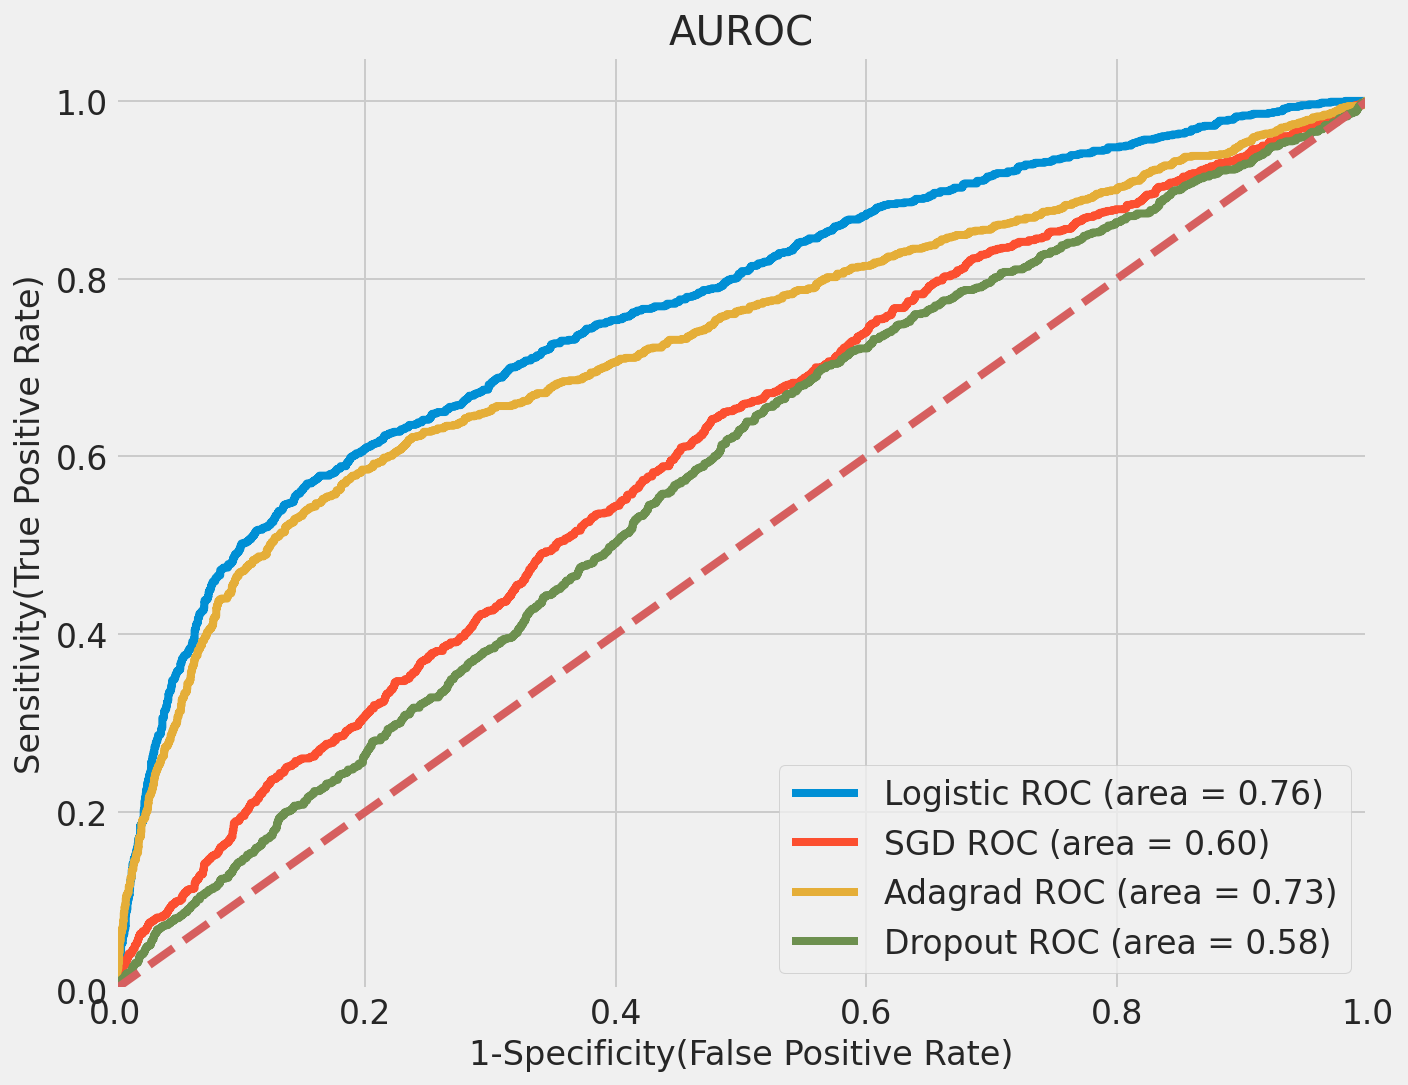

In [70]:

from sklearn import metrics

# false positive rate,fpr= FP/(TN+FP) OR fpr=1-specificty, tpr=sensitivity 
y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)

y_pred_3 = model3.predict(X_test)
y_pred_4 = model4.predict(X_test)

model = [model1,model2,model3,model4]

models=[y_pred_1,y_pred_2,y_pred_3,y_pred_4]
label=['Logistic','SGD','Adagrad','Dropout']

# plotting ROC curves
plt.figure(figsize=(10, 8))
m=np.arange(4)
for m in m:
    fpr, tpr,thresholds= metrics.roc_curve(y_test,models[m])
    auc = metrics.roc_auc_score(y_test,model[m].predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (label[m], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('AUROC')
plt.legend(loc="lower right")
plt.show()

## Weights analysis <br>
We will only visualize the changed weights of the regularized NN models 

In [71]:
print('Layers name:', model1.weights[6].name)
print('Layers kernel shape:', model1.weights[6].shape)
print('Kernel:', model1.weights[6][0], end = '\n\n')
print('Layers name:', model1.weights[7].name)
print('Layers kernel shape:', model1.weights[7].shape)
print('Kernel:', model1.weights[7])

Layers name: dense_3/kernel:0
Layers kernel shape: (128, 1)
Kernel: tf.Tensor([-0.18634975], shape=(1,), dtype=float32)

Layers name: dense_3/bias:0
Layers kernel shape: (1,)
Kernel: <tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([-0.03205981], dtype=float32)>


In [72]:
print('Layers name:', model2.weights[6].name)
print('Layers kernel shape:', model2.weights[6].shape)
print('Kernel:', model2.weights[6][0], end = '\n\n')
print('Layers name:', model2.weights[7].name)
print('Layers kernel shape:', model2.weights[7].shape)
print('Kernel:', model2.weights[7])

Layers name: dense_7/kernel:0
Layers kernel shape: (128, 256)
Kernel: tf.Tensor(
[-0.09121847 -0.06580094 -0.05886397  0.04242266  0.07936168  0.08133792
  0.11581239  0.04431101  0.08665863 -0.09298962 -0.03784756 -0.06398134
  0.11737202 -0.07968852 -0.006093    0.04736356  0.03106538 -0.05991751
  0.05386754  0.03977131 -0.08826541  0.08914691  0.01122509  0.02050287
 -0.07809737  0.08993889  0.08810749 -0.06545163  0.06879011 -0.06678367
 -0.02090723  0.10875532 -0.07407819 -0.09490134  0.07840285  0.06101397
 -0.11774934  0.08349272 -0.08776641  0.07972108 -0.00291166  0.10558608
  0.07704613  0.11935954  0.11669519 -0.03163965  0.06547346  0.02116547
  0.04131978 -0.08035854 -0.06935828 -0.09144342 -0.07582882 -0.03259559
  0.09958144  0.01731156 -0.11337756 -0.00491414 -0.02297328  0.06196862
  0.0492592   0.08216521 -0.11368985  0.09327267 -0.08557399  0.09117559
  0.00136779  0.09254041  0.06628907  0.03087101 -0.04027839  0.04396434
 -0.03797689 -0.08924364  0.11452079 -0.027

In [73]:
print('Layers name:', model3.weights[6].name)
print('Layers kernel shape:', model3.weights[6].shape)
print('Kernel:', model3.weights[6][0], end = '\n\n')
print('Layers name:', model3.weights[7].name)
print('Layers kernel shape:', model3.weights[7].shape)
print('Kernel:', model3.weights[7])

Layers name: dense_12/kernel:0
Layers kernel shape: (256, 512)
Kernel: tf.Tensor(
[ 5.40454313e-02  3.45593467e-02  7.43306279e-02  8.38639736e-02
  1.48161743e-02 -2.46261386e-03 -8.33915472e-02 -2.14971397e-02
  1.28278434e-02  3.85981351e-02  1.34389251e-02  5.07992432e-02
  1.71737913e-02  2.70692874e-02  1.97718590e-02 -5.43695688e-02
  2.79483721e-02 -3.20932977e-02 -5.21533974e-02  5.83487041e-02
 -2.09637806e-02  5.07951155e-02  6.76622672e-04 -4.28668745e-02
 -7.13762417e-02 -2.59192325e-02  7.99793750e-02  7.38484859e-02
  1.80097725e-02 -3.97977559e-03  8.55906308e-02  7.55896047e-03
 -5.84432930e-02  5.53421341e-02  3.30296382e-02 -8.01620036e-02
  8.68781954e-02  2.00015213e-02  7.91561082e-02 -1.34585230e-02
  8.44215304e-02  1.49836093e-02 -2.29809079e-02 -6.50281310e-02
  7.56700635e-02 -4.88767251e-02 -2.04061512e-02  2.48906370e-02
 -7.86376521e-02 -5.99745028e-02  8.26498717e-02  5.07423654e-02
 -2.65832413e-02 -3.24078985e-02 -5.44772819e-02  9.82866623e-03
  2.6760

In [74]:
print('Layers name:', model4.weights[6].name)
print('Layers kernel shape:', model4.weights[6].shape)
print('Kernel:', model4.weights[6][0], end = '\n\n')
print('Layers name:', model4.weights[7].name)
print('Layers kernel shape:', model4.weights[7].shape)
print('Kernel:', model4.weights[7])

Layers name: dense_17/kernel:0
Layers kernel shape: (512, 1)
Kernel: tf.Tensor([0.09713914], shape=(1,), dtype=float32)

Layers name: dense_17/bias:0
Layers kernel shape: (1,)
Kernel: <tf.Variable 'dense_17/bias:0' shape=(1,) dtype=float32, numpy=array([-0.02039381], dtype=float32)>
